In [371]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
from sklearn.model_selection import validation_curve, learning_curve, cross_validate, cross_val_score, LearningCurveDisplay

# Preprocessing

In [52]:
cars = pd.read_csv('data/car.data', names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'target'])
cars['target'] = cars['target'].apply(lambda x: 0 if x == 'unacc' else 1)

Y = cars['target']

skencoder = OneHotEncoder(drop='first',sparse_output=False)
skencoder.set_output(transform="pandas")
ohe_cars = skencoder.fit_transform(cars.loc[:,['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']])
ohe_cars['target'] = Y

cars_x = ohe_cars.loc[:, ohe_cars.columns != 'target']
cars_y = ohe_cars['target']


oencoder = OrdinalEncoder()
oencoder.set_output(transform='pandas')
ordinal_cars = oencoder.fit_transform(cars.loc[:,['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']])
ordinal_cars['target'] = Y
cars_unencoded_x = ordinal_cars.loc[:, ordinal_cars.columns != 'target']
cars_unencoded_y = ordinal_cars['target']

(n_samples_cars, n_features_cars), n_digits_cars = cars_x.shape, np.unique(cars_y).size
(n_samples_cars_unencoded, n_features_cars_unencoded), n_digits_cars_unencoded = cars_unencoded_x.shape, np.unique(cars_unencoded_y).size

# X_train, X_test, y_train, y_test = train_test_split(cars_x, cars_y, test_size = 0.2, random_state=0)

beans = pd.read_excel('data/Dry_Bean_Dataset.xlsx', engine='openpyxl')
le = LabelEncoder()
beans['Class'] = le.fit_transform(beans['Class'])
beans = beans.groupby('Class', group_keys=False).apply(lambda x: x.sample(500))
beans_x = beans.loc[:, beans.columns != 'Class']
beans_y = beans['Class']
# don't need to scale the data as it will be scaled in the benchmark test code
# scaler = StandardScaler() 
# beans_scaled = scaler.fit_transform(beans_x)

# beans_x = pd.DataFrame(beans_scaled, index=beans_x.index, columns=beans_x.columns)

(n_samples_beans, n_features_beans), n_digits_beans = beans_x.shape, np.unique(beans_y).size

# X_train, X_test, y_train, y_test = train_test_split(beans_x, beans_y, test_size = 0.2, random_state=_random_state)
print(f"# digits cars: {n_digits_cars}; # samples cars: {n_samples_cars}; # features cars: {n_features_cars}")
print(f"# digits cars (not one hot encoded): {n_digits_cars_unencoded}; # samples cars: {n_samples_cars_unencoded}; # features cars: {n_features_cars_unencoded}")
print(f"# digits beans: {n_digits_beans}; # samples beans: {n_samples_beans}; # features beans: {n_features_beans}")

# digits cars: 2; # samples cars: 1728; # features cars: 15
# digits cars (not one hot encoded): 2; # samples cars: 1728; # features cars: 6
# digits beans: 7; # samples beans: 3500; # features beans: 16


# Clustering

## KMeans

In [43]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    # clustering_metrics = [
    #     metrics.homogeneity_score,
    #     metrics.completeness_score,
    #     metrics.v_measure_score,
    #     metrics.adjusted_rand_score,
    #     metrics.adjusted_mutual_info_score,
    # ]
    # results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            random_state=0
        ),
        metrics.calinski_harabasz_score(
            data,
            estimator[-1].labels_
        ),
        metrics.davies_bouldin_score(
            data,
            estimator[-1].labels_
        )
    ]

    # Show the results
    # formatter_result = (
    #     "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    # )
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [44]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tinertia\tsilhouette\tch\tdb")
kmeans = KMeans(init="k-means++", n_clusters=n_digits_cars, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=cars_x, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=3", data=cars_x, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=4", data=cars_x, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=5", data=cars_x, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=n_digits_cars, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=cars_x, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=cars_x, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=cars_x, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=5", data=cars_x, labels=cars_y)

__________________________________________________________________________________
init		time	inertia	silhouette	ch	db
k-means++	0.028s	24015	0.079	150.850	3.370
n=3      	0.032s	22072	0.098	139.603	3.027
n=4      	0.032s	20918	0.089	131.381	2.845
n=5      	0.033s	19824	0.090	120.762	2.634
random   	0.255s	23760	0.095	174.785	2.929
random n=4	0.259s	21888	0.106	146.069	2.865
random n=4	0.257s	20784	0.100	129.999	2.766
random n=5	0.261s	19824	0.090	120.762	2.634


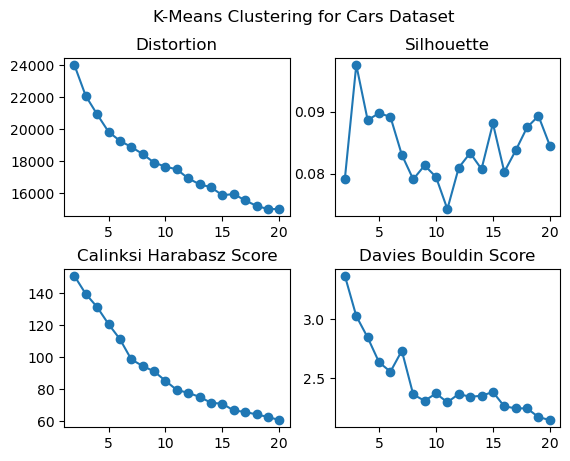

In [130]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(cars_x)
    distortion.append(estimator[-1].inertia_)
    silhouette.append(metrics.silhouette_score(
        cars_x,
        estimator[-1].labels_,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            cars_x,
            estimator[-1].labels_
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            cars_x,
            estimator[-1].labels_
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(2,2, hspace=0.33)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('K-Means Clustering for Cars Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(2, 21), distortion, marker='o')
axs[0, 0].set_title('Distortion')
# axs[0, 0].set(xlabel='Number of clusters', ylabel='Distortion')
axs[0, 1].plot(range(2, 21), silhouette, marker='o')
axs[0, 1].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1, 0].plot(range(2, 21), ch, marker='o')
axs[1, 0].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[1, 1].plot(range(2, 21), db, marker='o')
axs[1, 1].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()


In [80]:
kmeans_cars = KMeans(init="random", n_clusters=n_digits_cars, n_init='auto', random_state=0)
estimator = make_pipeline(StandardScaler(), kmeans_cars).fit(cars_x)

homogeneity = metrics.homogeneity_score(cars_y,estimator[-1].labels_)
vscore = metrics.v_measure_score(cars_y,estimator[-1].labels_)
completeness = metrics.completeness_score(cars_y,estimator[-1].labels_)
print('Homogeneity: ', homogeneity)
print('V Score :', vscore)
print('Completeness', completeness)

Homogeneity:  0.0007506277663330084
V Score : 0.0007350720432870244
Completeness 0.0007201479718567114


In [65]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tinertia\tsilhouette\tch\tdb")
kmeans = KMeans(init="k-means++", n_clusters=n_digits_cars_unencoded, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=cars_unencoded_x, labels=cars_unencoded_y)

kmeans = KMeans(init="k-means++", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=3", data=cars_unencoded_x, labels=cars_unencoded_y)

kmeans = KMeans(init="k-means++", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=4", data=cars_unencoded_x, labels=cars_unencoded_y)

kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=5", data=cars_unencoded_x, labels=cars_unencoded_y)

kmeans = KMeans(init="random", n_clusters=n_digits_cars, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=cars_unencoded_x, labels=cars_unencoded_y)

kmeans = KMeans(init="random", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=3", data=cars_unencoded_x, labels=cars_unencoded_y)

kmeans = KMeans(init="random", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=cars_unencoded_x, labels=cars_unencoded_y)

kmeans = KMeans(init="random", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=5", data=cars_unencoded_x, labels=cars_unencoded_y)

__________________________________________________________________________________
init		time	inertia	silhouette	ch	db
k-means++	0.025s	9209	0.137	284.778	2.410
n=3      	0.032s	8248	0.116	238.020	2.416
n=4      	0.032s	7636	0.110	215.640	2.023
n=5      	0.033s	7079	0.110	199.693	2.101
random   	0.249s	8986	0.166	363.368	2.143
random n=3	0.259s	8150	0.112	219.545	2.360
random n=4	0.259s	7544	0.088	135.309	2.617
random n=5	0.280s	7082	0.095	156.585	2.239


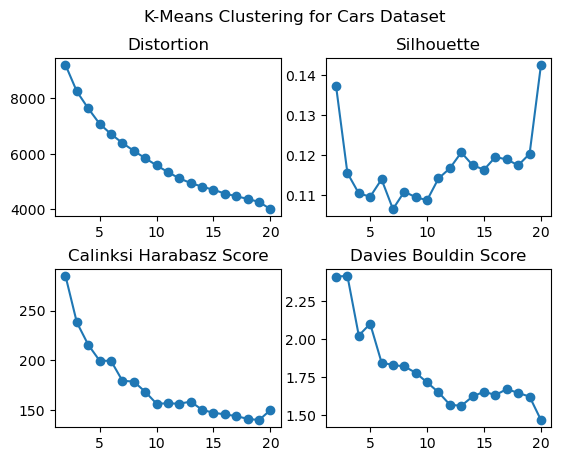

In [127]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(cars_unencoded_x)
    distortion.append(estimator[-1].inertia_)
    silhouette.append(metrics.silhouette_score(
        cars_unencoded_x,
        estimator[-1].labels_,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            cars_unencoded_x,
            estimator[-1].labels_
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            cars_unencoded_x,
            estimator[-1].labels_
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(2,2, hspace=0.33)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('K-Means Clustering for Cars Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(2, 21), distortion, marker='o')
axs[0, 0].set_title('Distortion')
# axs[0, 0].set(xlabel='Number of clusters', ylabel='Distortion')
axs[0, 1].plot(range(2, 21), silhouette, marker='o')
axs[0, 1].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1, 0].plot(range(2, 21), ch, marker='o')
axs[1, 0].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[1, 1].plot(range(2, 21), db, marker='o')
axs[1, 1].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()




In [79]:
kmeans_cars = KMeans(init="random", n_clusters=n_digits_cars, n_init='auto', random_state=0)
estimator = make_pipeline(StandardScaler(), kmeans_cars).fit(cars_unencoded_x)

homogeneity = metrics.homogeneity_score(cars_unencoded_y,estimator[-1].labels_)
vscore = metrics.v_measure_score(cars_unencoded_y,estimator[-1].labels_)
completeness = metrics.completeness_score(cars_unencoded_y,estimator[-1].labels_)
print('Homogeneity: ', homogeneity)
print('V Score :', vscore)
print('Completeness', completeness)

Homogeneity:  0.002766925533990299
V Score : 0.0025918902725495557
Completeness 0.002437682850008101


In [395]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tinertia\tsilhouette\tch\tdb")


kmeans = KMeans(init="k-means++", n_clusters=2, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=beans_x, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=beans_x, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=beans_x, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=beans_x, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=6, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=beans_x, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=n_digits_beans, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=beans_x, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=8, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++ 8", data=beans_x, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=9, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++ 9", data=beans_x, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=10, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++ 10", data=beans_x, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=11, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++ 11", data=beans_x, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=12, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++ 12", data=beans_x, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random 3", data=beans_x, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=n_digits_beans, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=beans_x, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=8, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random 8", data=beans_x, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=9, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random 9", data=beans_x, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=10, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random 10", data=beans_x, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=11, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random 11", data=beans_x, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=12, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random 12", data=beans_x, labels=beans_y)

__________________________________________________________________________________
init		time	inertia	silhouette	ch	db
k-means++	0.026s	35014	0.308	1847.313	0.883
k-means++	0.029s	21661	0.467	16531.268	0.587
k-means++	0.026s	18314	0.341	12852.097	0.964
k-means++	0.027s	14656	0.204	12415.572	8.875
k-means++	0.027s	12981	0.119	9566.262	9.027
k-means++	0.030s	11811	0.057	7574.264	12.952
k-means++ 8	0.028s	11060	0.059	6950.486	5.749
k-means++ 9	0.029s	10278	0.034	6091.729	14.386
k-means++ 10	0.032s	9538	-0.038	6976.400	4.658
k-means++ 11	0.039s	9120	-0.043	6297.910	8.371
k-means++ 12	0.028s	8648	-0.046	5724.850	5.998
random 3 	0.265s	21661	0.467	16541.286	0.586
random   	0.277s	11811	0.057	7574.000	13.208
random 8 	0.249s	11058	0.058	6826.570	7.338
random 9 	0.260s	10534	0.021	5701.909	11.801
random 10	0.266s	9539	-0.035	7005.399	4.687
random 11	0.262s	9068	-0.040	6335.310	5.795
random 12	0.264s	8678	-0.048	5778.622	6.110


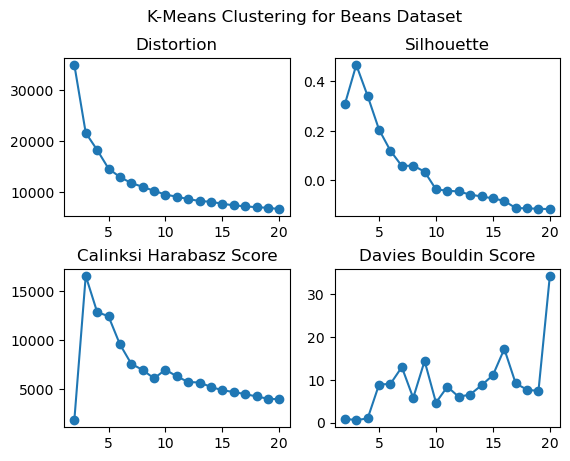

In [137]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(beans_x)
    distortion.append(estimator[-1].inertia_)
    silhouette.append(metrics.silhouette_score(
        beans_x,
        estimator[-1].labels_,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            beans_x,
            estimator[-1].labels_
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            beans_x,
            estimator[-1].labels_
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(2,2, hspace=0.33)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('K-Means Clustering for Beans Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(2, 21), distortion, marker='o')
axs[0, 0].set_title('Distortion')
# axs[0, 0].set(xlabel='Number of clusters', ylabel='Distortion')
axs[0, 1].plot(range(2, 21), silhouette, marker='o')
axs[0, 1].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1, 0].plot(range(2, 21), ch, marker='o')
axs[1, 0].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[1, 1].plot(range(2, 21), db, marker='o')
axs[1, 1].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [78]:
kmeans_beans = KMeans(init="k-means++", n_clusters=3, n_init='auto', random_state=0)
estimator = make_pipeline(StandardScaler(), kmeans_beans).fit(beans_x)

homogeneity = metrics.homogeneity_score(beans_y,estimator[-1].labels_)
vscore = metrics.v_measure_score(beans_y,estimator[-1].labels_)
completeness = metrics.completeness_score(beans_y,estimator[-1].labels_)
print('Homogeneity: ', homogeneity)
print('V Score :', vscore)
print('Completeness', completeness)

Homogeneity:  0.41710814733902324
V Score : 0.5505068253054426
Completeness 0.8093521957812159


## Expectation Maximization Gaussian Mixture

In [142]:
def bench_gm(gm, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    gm_results = make_pipeline(StandardScaler(), gm).fit_predict(data)
    fit_time = time() - t0
    results = [name, fit_time]

    # Define the metrics which require only the true labels and estimator
    # labels
    # clustering_metrics = [
    #     metrics.homogeneity_score,
    #     metrics.completeness_score,
    #     metrics.v_measure_score,
    #     metrics.adjusted_rand_score,
    #     metrics.adjusted_mutual_info_score,
    # ]
    # results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            gm_results,
            metric="euclidean",
            random_state=0
        ),
        metrics.calinski_harabasz_score(
            data,
            gm_results
        ),
        metrics.davies_bouldin_score(
            data,
            gm_results
        )
    ]

    # Show the results
    # formatter_result = (
    #     "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    # )
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [143]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tsilhouette\tch\tdb")

gm = GaussianMixture(n_components=n_digits_cars, random_state=0)
bench_gm(gm=gm, name="Gaussian 2", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0)
bench_gm(gm=gm, name="Gaussian 3", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0)
bench_gm(gm=gm, name="Gaussian 4", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0)
bench_gm(gm=gm, name="Gaussian 5", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0)
bench_gm(gm=gm, name="Gaussian 6", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=n_digits_cars, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 2 ++", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 3 ++", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 4 ++", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 5 ++", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 6 ++", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=n_digits_cars, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 2 random", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 3 random", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 4 random", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 5 random", data=cars_x, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 6 random", data=cars_x, labels=cars_y)

__________________________________________________________________________________
init		time	silhouette	ch	db
Gaussian 2	0.044s	0.085	158.834	3.236
Gaussian 3	0.039s	0.098	139.603	3.027
Gaussian 4	0.037s	0.089	131.381	2.845
Gaussian 5	0.039s	0.090	120.762	2.634
Gaussian 6	0.042s	0.089	111.377	2.553
Gaussian 2 ++	0.012s	0.083	141.687	2.949
Gaussian 3 ++	0.013s	0.074	117.102	3.247
Gaussian 4 ++	0.016s	0.071	109.039	3.084
Gaussian 5 ++	0.021s	0.073	104.560	2.805
Gaussian 6 ++	0.027s	0.065	96.475	2.700
Gaussian 2 random	0.012s	0.064	114.221	3.876
Gaussian 3 random	0.016s	0.023	59.620	4.762
Gaussian 4 random	0.028s	0.037	64.097	3.900
Gaussian 5 random	0.027s	0.018	66.434	3.290
Gaussian 6 random	0.029s	0.018	59.547	3.534


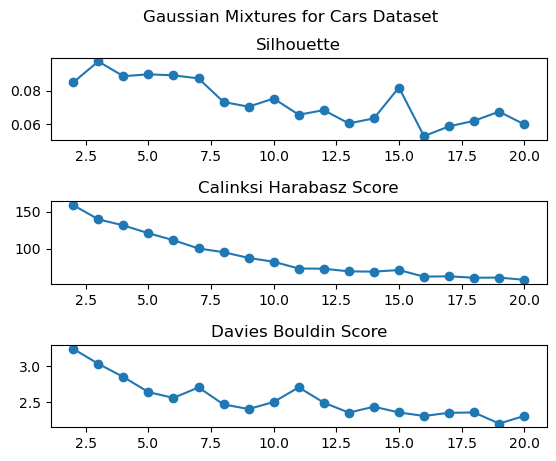

In [139]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    # kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    gm = GaussianMixture(n_components=i, random_state=0)
    results = make_pipeline(StandardScaler(), gm).fit_predict(cars_x)
    silhouette.append(metrics.silhouette_score(
        cars_x,
        results,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            cars_x,
            results
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            cars_x,
            results
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0.75)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('Gaussian Mixtures for Cars Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0].plot(range(2, 21), silhouette, marker='o')
axs[0].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1].plot(range(2, 21), ch, marker='o')
axs[1].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[2].plot(range(2, 21), db, marker='o')
axs[2].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [144]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tsilhouette\tch\tdb")

gm = GaussianMixture(n_components=n_digits_cars_unencoded, random_state=0)
bench_gm(gm=gm, name="Gaussian 2", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=3, random_state=0)
bench_gm(gm=gm, name="Gaussian 3", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=4, random_state=0)
bench_gm(gm=gm, name="Gaussian 4", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=5, random_state=0)
bench_gm(gm=gm, name="Gaussian 5", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=6, random_state=0)
bench_gm(gm=gm, name="Gaussian 6", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=20, random_state=0)
bench_gm(gm=gm, name="Gaussian 20", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=n_digits_cars_unencoded, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 2 ++", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 3 ++", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 4 ++", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 5 ++", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 6 ++", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=n_digits_cars_unencoded, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 2 random", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 3 random", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 4 random", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 5 random", data=cars_unencoded_x, labels=cars_unencoded_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 6 random", data=cars_unencoded_x, labels=cars_unencoded_y)

__________________________________________________________________________________
init		time	silhouette	ch	db
Gaussian 2	0.031s	0.138	284.915	2.402
Gaussian 3	0.053s	0.112	219.545	2.360
Gaussian 4	0.060s	0.054	120.982	3.692
Gaussian 5	0.070s	0.044	109.645	3.209
Gaussian 6	0.052s	0.034	133.001	2.107
Gaussian 20	0.169s	-0.219	27.090	2.624
Gaussian 2 ++	0.013s	0.121	211.700	2.060
Gaussian 3 ++	0.019s	0.090	181.579	2.523
Gaussian 4 ++	0.018s	0.095	202.824	2.143
Gaussian 5 ++	0.025s	0.044	109.645	3.209
Gaussian 6 ++	0.037s	0.015	101.016	2.893
Gaussian 2 random	0.005s	0.024	26.515	7.927
Gaussian 3 random	0.005s	0.011	38.325	5.587
Gaussian 4 random	0.005s	0.017	54.391	5.447
Gaussian 5 random	0.006s	0.021	77.649	3.986
Gaussian 6 random	0.008s	0.005	37.702	5.303


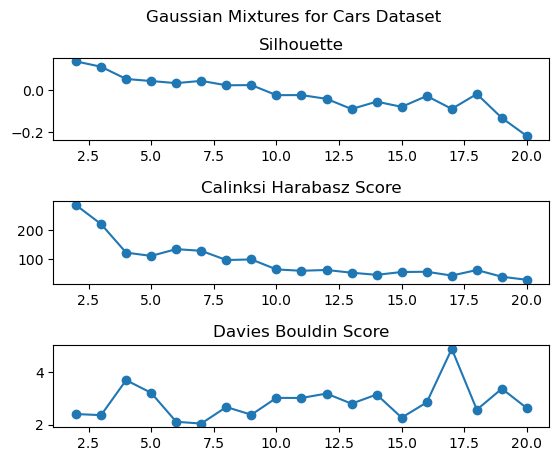

In [140]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    # kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    gm = GaussianMixture(n_components=i, random_state=0)
    results = make_pipeline(StandardScaler(), gm).fit_predict(cars_unencoded_x)
    silhouette.append(metrics.silhouette_score(
        cars_unencoded_x,
        results,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            cars_unencoded_x,
            results
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            cars_unencoded_x,
            results
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0.75)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('Gaussian Mixtures for Cars Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0].plot(range(2, 21), silhouette, marker='o')
axs[0].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1].plot(range(2, 21), ch, marker='o')
axs[1].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[2].plot(range(2, 21), db, marker='o')
axs[2].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [147]:
gm = GaussianMixture(n_components=2, random_state=0)
results = make_pipeline(StandardScaler(), gm).fit_predict(cars_unencoded_x)

aic = gm.aic(cars_unencoded_x)
bic = gm.bic(cars_unencoded_x)
density = gm.predict_proba(cars_unencoded_x)
print('AIC: ', aic)
print('BIC:', bic)
print('Density:', density)

AIC:  47955.846457338565
BIC: 48255.85605455359
Density: [[6.02909782e-03 9.93970902e-01]
 [9.68145848e-03 9.90318542e-01]
 [3.78002793e-03 9.96219972e-01]
 ...
 [1.15473042e-03 9.98845270e-01]
 [1.81937629e-03 9.98180624e-01]
 [7.38718151e-04 9.99261282e-01]]


c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(


In [148]:
len(density)

1728

In [150]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tsilhouette\tch\tdb")

gm = GaussianMixture(n_components=2, random_state=0)
bench_gm(gm=gm, name="Gaussian 2", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0)
bench_gm(gm=gm, name="Gaussian 3", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0)
bench_gm(gm=gm, name="Gaussian 4", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0)
bench_gm(gm=gm, name="Gaussian 5", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0)
bench_gm(gm=gm, name="Gaussian 6", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=n_digits_beans, random_state=0)
bench_gm(gm=gm, name="Gaussian 7", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=8, random_state=0)
bench_gm(gm=gm, name="Gaussian 8", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=9, random_state=0)
bench_gm(gm=gm, name="Gaussian 9", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=10, random_state=0)
bench_gm(gm=gm, name="Gaussian 10", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=2, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 2", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 3", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 4", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 5", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 6", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=7, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 7", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=8, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 8", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=9, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 9", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=10, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 10", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=2, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 2", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 3", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 4", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 5", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 6", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=7, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 7", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=8, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 8", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=9, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 9", data=beans_x, labels=beans_y)

gm = GaussianMixture(n_components=10, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 10", data=beans_x, labels=beans_y)


__________________________________________________________________________________
init		time	silhouette	ch	db
Gaussian 2	0.038s	0.322	1912.526	0.862
Gaussian 3	0.067s	0.568	20370.836	0.473
Gaussian 4	0.149s	0.450	18065.739	0.593
Gaussian 5	0.068s	0.224	13186.814	4.944
Gaussian 6	0.173s	0.103	10660.723	10.638
Gaussian 7	0.175s	0.105	8595.602	12.842
Gaussian 8	0.146s	0.122	7803.830	4.674
Gaussian 9	0.164s	0.110	7008.057	2.826
Gaussian 10	0.161s	0.010	7876.746	2.498
Gaussian 2	0.016s	0.322	1911.121	0.862
Gaussian 3	0.037s	0.568	20413.067	0.473
Gaussian 4	0.070s	0.324	12456.112	5.480
Gaussian 5	0.062s	0.099	10596.551	8.070
Gaussian 6	0.117s	0.107	10710.360	31.417
Gaussian 7	0.083s	0.121	8687.605	7.665
Gaussian 8	0.108s	0.155	8972.467	1.382
Gaussian 9	0.172s	0.144	7689.696	11.144
Gaussian 10	0.168s	0.088	9805.331	4.718
Gaussian 2	0.039s	0.298	578.972	2.119
Gaussian 3	0.053s	0.566	19492.802	0.475
Gaussian 4	0.050s	0.458	17171.024	0.593
Gaussian 5	0.082s	0.317	6342.656	3.273
Gaussian 6	0.199

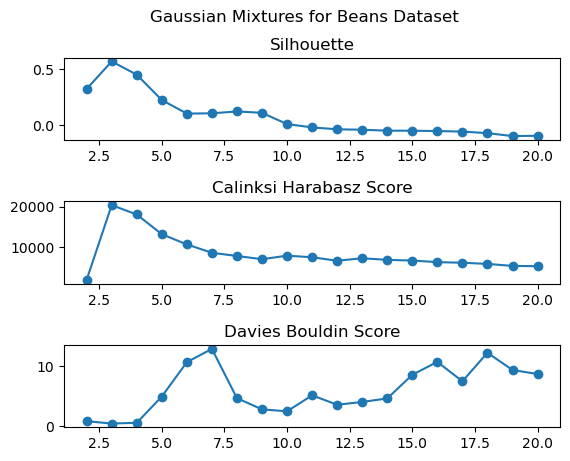

In [151]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    # kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    gm = GaussianMixture(n_components=i, random_state=0)
    results = make_pipeline(StandardScaler(), gm).fit_predict(beans_x)
    silhouette.append(metrics.silhouette_score(
        beans_x,
        results,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            beans_x,
            results
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            beans_x,
            results
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0.75)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('Gaussian Mixtures for Beans Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0].plot(range(2, 21), silhouette, marker='o')
axs[0].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1].plot(range(2, 21), ch, marker='o')
axs[1].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[2].plot(range(2, 21), db, marker='o')
axs[2].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [152]:
gm = GaussianMixture(n_components=3, random_state=0)
results = make_pipeline(StandardScaler(), gm).fit_predict(beans_x)

aic = gm.aic(beans_x)
bic = gm.bic(beans_x)
density = gm.predict_proba(beans_x)
print('AIC: ', aic)
print('BIC:', bic)
print('Density:', density)

AIC:  2.2827107535604157e+18
BIC: 2.2827107535604186e+18
Density: [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(


# Dimensionality Reduction

## PCA

In [245]:
def pca_feature_correlation(X, X_pca, explained_var, features:list=None, fig_dpi:int=150, save_plot:bool=False):
    """
    1. Get dot product of X and X_pca
    2. Run normalizations of X*X_pca
    3. Retrieve df/matrices
    X:               data (numpy matrix)
    X_pca:           PCA
    explained_var:   explained variance matrix
    features:        list of feature names
    fig_dpi:         dpi to use for heatmaps
    save_plot:       save plot to file (html) and not show
    """
    
    # Add zeroes for data where features > instances
    outer_diff = X.T.shape[0] - X_pca.shape[1]
    if outer_diff > 0: # outer dims must match to get sq matrix
        Z = np.zeros([X_pca.shape[0], outer_diff])
        X_pca = np.c_[X_pca, Z]
        explained_var = np.append(explained_var, np.zeros(outer_diff))
    
    # Get correlation between original features (X) and PCs (X_pca)
    dot_matrix = np.dot(X.T, X_pca)
    print(f"X*X_pca: {X.T.shape} * {X_pca.shape} = {dot_matrix.shape}")
    
    # Correlation matrix -> df
    df_dotproduct = pd.DataFrame(dot_matrix)
    df_dotproduct.columns = [''.join(['PC', f'{i+1}']) for i in range(dot_matrix.shape[0])]
    if any(features): df_dotproduct.index = features    
    
    # Normalize & Sort
    df_n, df_na, df_nabv = normalize_dataframe(df_dotproduct, explained_var, plot_opt=True, save_plot=save_plot)
    
    return df_dotproduct, df_n, df_na, df_nabv


def normalize_dataframe(df, explained_var=None, fig_dpi:int=150, plot_opt:bool=True, save_plot:bool=False):
    """
    1. Get z-normalized df (normalized to µ=0, σ=1)
    2. Get absolute value of z-normalized df
    3. If explained_variance matrix provided, dot it w/ (2)
    """
    # Normalize, Reindex, & Sort
    df_norm = (df.copy()-df.mean())/df.std()
    df_norm = df_norm.sort_values(list(df_norm.columns), ascending=False)
    
    # Absolute value of normalized (& sort)
    df_abs = df_norm.copy().abs().set_index(df_norm.index)
    df_abs = df_abs.sort_values(by=list(df_abs.columns), ascending=False)
    
    # Plot
    if plot_opt:
        # Z-normalized corr matrix
        plt.figure(dpi=fig_dpi)
        ax_normal = sns.heatmap(df_norm, cmap="RdBu")
        ax_normal.set_title("Z-Normalized Data")
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix.png')
        else:
            plt.show()

        # |Z-normalized corr matrix|  
        plt.figure(dpi=fig_dpi)
        ax_abs = sns.heatmap(df_abs, cmap="Purples")
        ax_abs.set_title("|Z-Normalized|")
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix_Abs.png')
        else:
            plt.show()
        
    # Re-normalize by explained var (& sort)
    if explained_var.any():
        df_byvar = df_abs.copy()*explained_var
        df_byvar = df_byvar.sort_values(by=list(df_norm.columns), ascending=False)
        if plot_opt:
            plt.figure(dpi=fig_dpi)
            ax_relative = sns.heatmap(df_byvar, cmap="Purples")
            ax_relative.set_title("|Z-Normalized|*Explained_Variance")
            if save_plot:
                plt.savefig('Normalized_corr_matrix.png')
            else:
                plt.show()
    else:
        df_byvar = None
    return df_norm, df_abs, df_byvar

In [246]:
pca = PCA(random_state=0)
pca.set_output(transform="pandas")
result = pca.fit_transform(cars_x)
eigenvalues = pca.explained_variance_

In [247]:
sum(pca.explained_variance_ratio_ * 100)

100.00000000000001

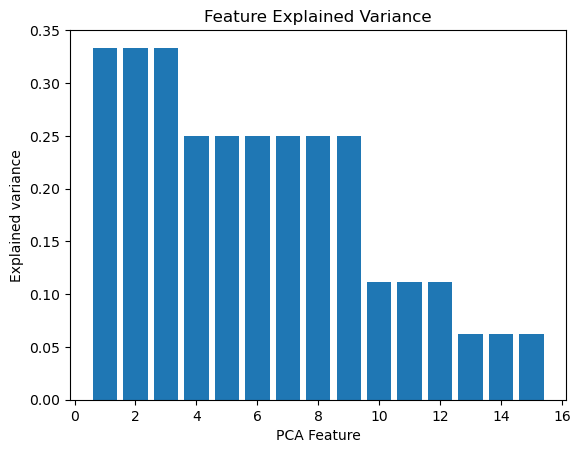

In [248]:
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

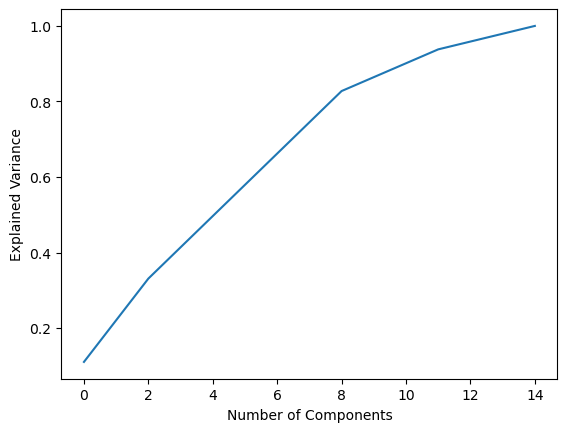

In [249]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

X*X_pca: (15, 1728) * (1728, 15) = (15, 15)


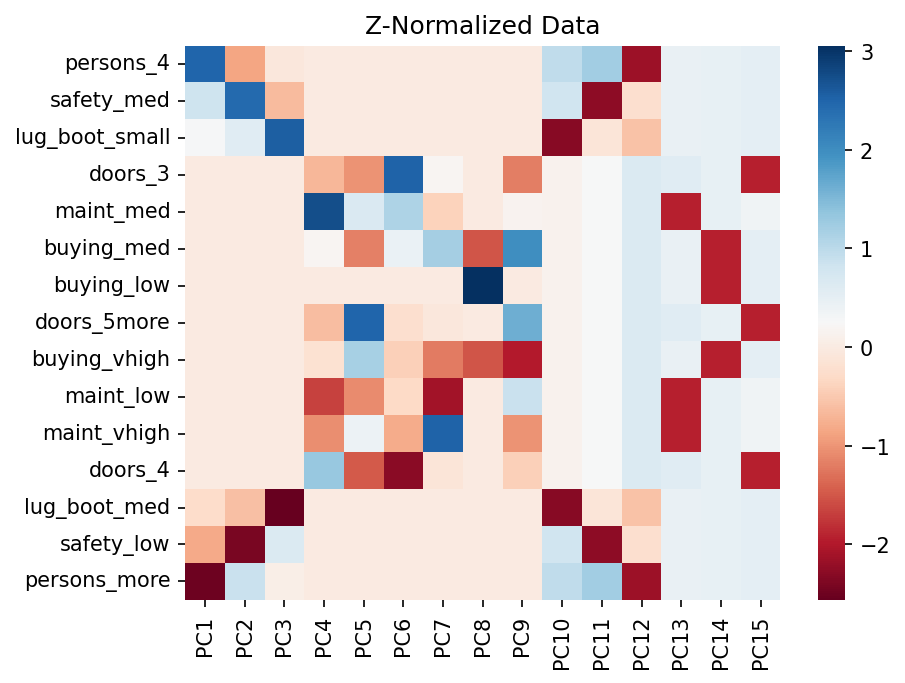

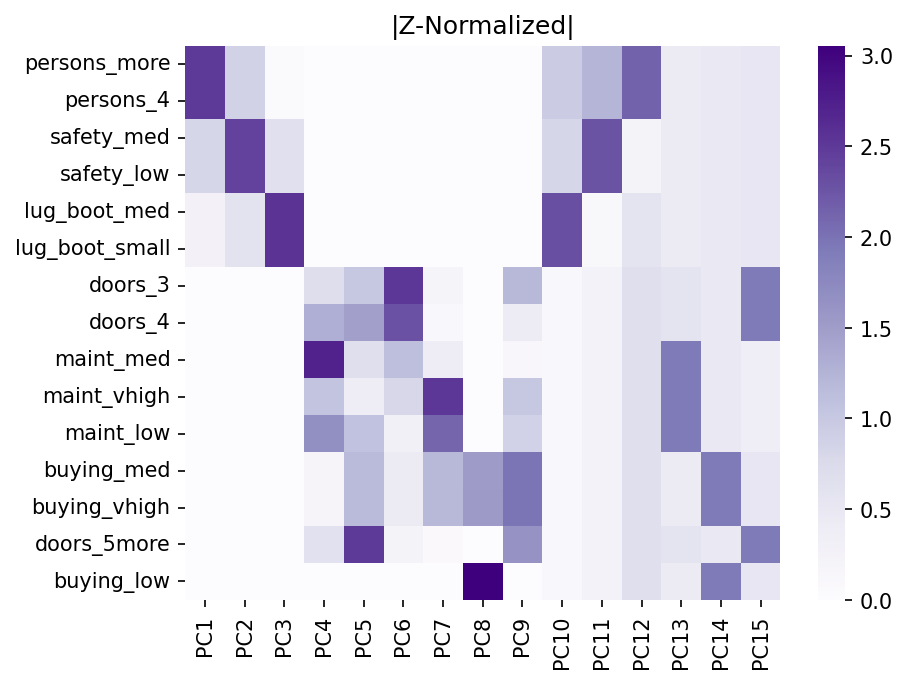

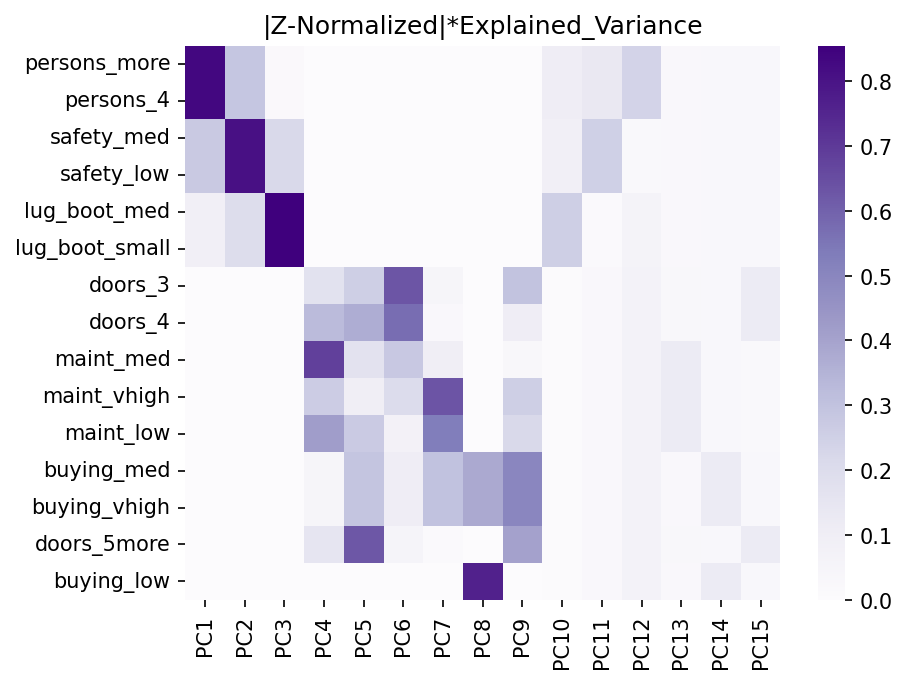

(                         PC1           PC2           PC3           PC4  \
 buying_low      1.265654e-14 -1.232348e-14  2.793946e-14 -9.436896e-15   
 buying_med      1.368794e-12  1.671940e-12 -1.089857e-13  2.187616e+01   
 buying_vhigh   -1.232126e-12 -1.718153e-12  1.716786e-13 -2.187616e+01   
 maint_low      -1.438627e-12  1.136979e-12  2.730767e-13 -1.929370e+02   
 maint_med       3.979705e-12 -4.073963e-13 -2.750508e-13  3.151311e+02   
 maint_vhigh    -2.444267e-12 -9.479084e-13  1.135723e-13 -1.221940e+02   
 doors_3         5.396017e-12 -1.027123e-12  4.812331e-13 -7.901947e+01   
 doors_4        -4.675926e-12 -2.965683e-13 -1.958433e-13  1.509482e+02   
 doors_5more    -7.476242e-13  1.322609e-12 -2.553895e-13 -7.192876e+01   
 persons_4       3.848648e+02 -1.329003e+02 -1.022837e+01 -1.517120e-12   
 persons_more   -3.848648e+02  1.329003e+02  1.022837e+01  1.114109e-12   
 lug_boot_med   -4.221979e+01 -9.189916e+01 -3.945377e+02  1.924017e-13   
 lug_boot_small  4.221979

In [250]:
pca_feature_correlation(cars_x, result, pca.explained_variance_, cars_x.columns) 

In [212]:
pca_cars = PCA(n_components=11, random_state=0)
pca_cars.set_output(transform="pandas")
result_pca_cars = pca_cars.fit_transform(cars_x)
eigenvalues_cars = pca_cars.explained_variance_

In [213]:
sum(pca.explained_variance_ratio_ * 100)

90.11494252873598

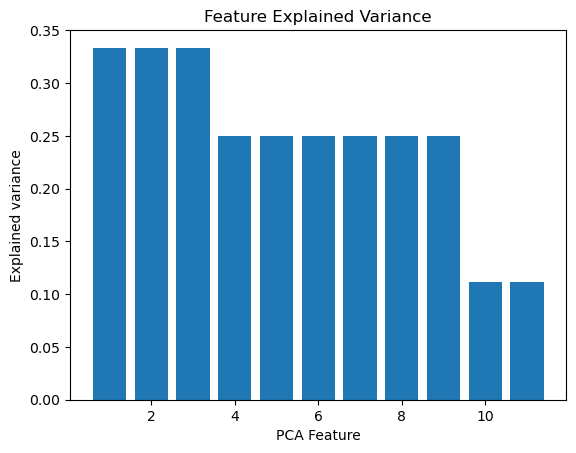

In [214]:
plt.bar(
    range(1,len(eigenvalues_cars)+1),
    eigenvalues_cars
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

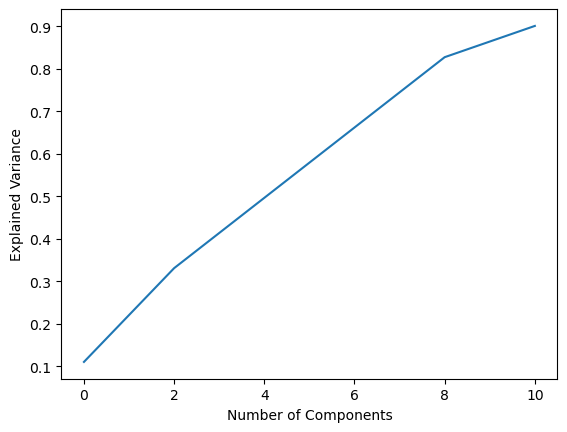

In [215]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

In [220]:
beans_x.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
2579,67808,1032.304,364.400420,238.508783,1.527828,0.756041,68798,293.829588,0.749028,0.985610,0.799605,0.806337,0.005374,0.001401,0.650180,0.993363
3079,78027,1183.251,366.686070,273.407218,1.341172,0.666375,79713,315.193690,0.752553,0.978849,0.700327,0.859574,0.004699,0.001583,0.738867,0.990947
3029,76546,1124.781,410.336651,238.440065,1.720922,0.813844,77760,312.188075,0.788858,0.984388,0.760320,0.760810,0.005361,0.001108,0.578831,0.996123
2775,71197,1032.165,376.298228,241.221986,1.559967,0.767508,72221,301.082772,0.775566,0.985821,0.839795,0.800117,0.005285,0.001336,0.640188,0.998672
2666,69229,1028.211,374.702605,236.669232,1.583233,0.775279,70463,296.892405,0.776937,0.982487,0.822874,0.792341,0.005413,0.001316,0.627805,0.993962


In [222]:
scaler = StandardScaler() 
beans_scaled = scaler.fit_transform(beans_x)

pca = PCA(random_state=0)
pca.set_output(transform="pandas")
result = pca.fit_transform(beans_scaled)
eigenvalues = pca.explained_variance_

In [224]:
sum(pca.explained_variance_ratio_ * 100)

99.99999999999997

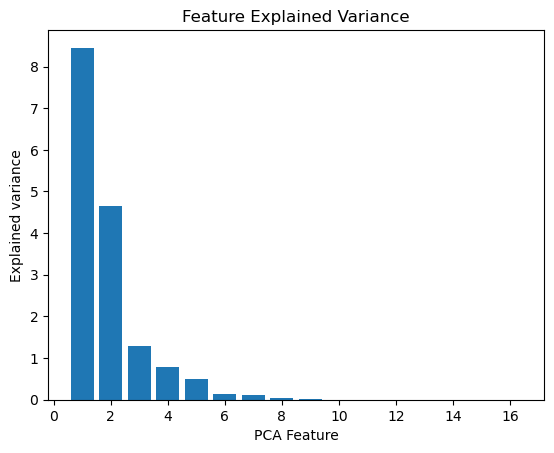

In [232]:
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

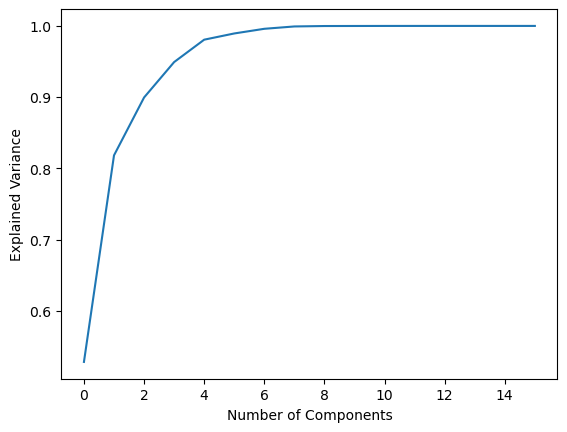

In [226]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

X*X_pca: (16, 3500) * (3500, 16) = (16, 16)


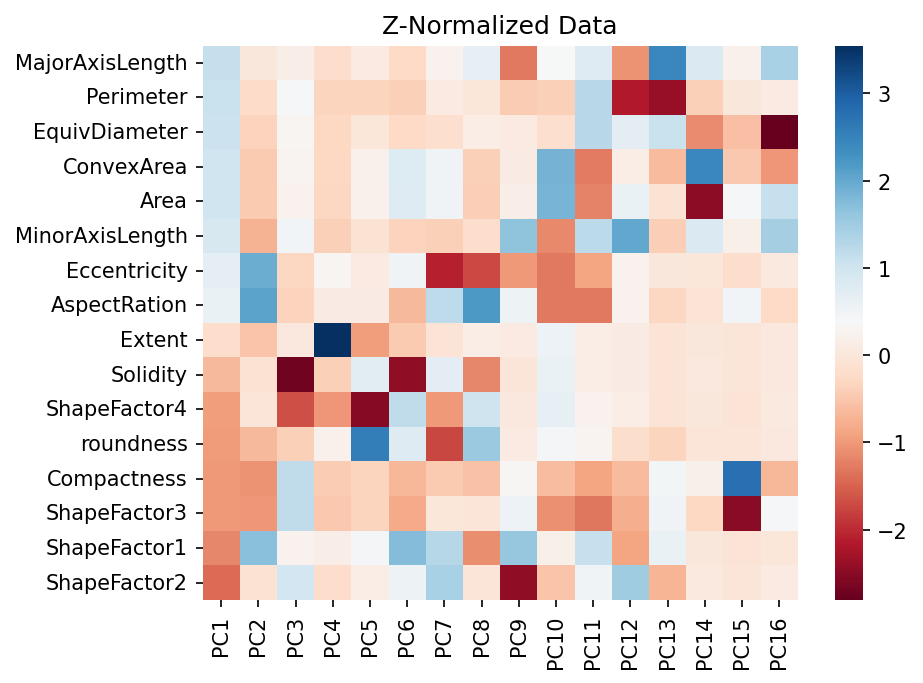

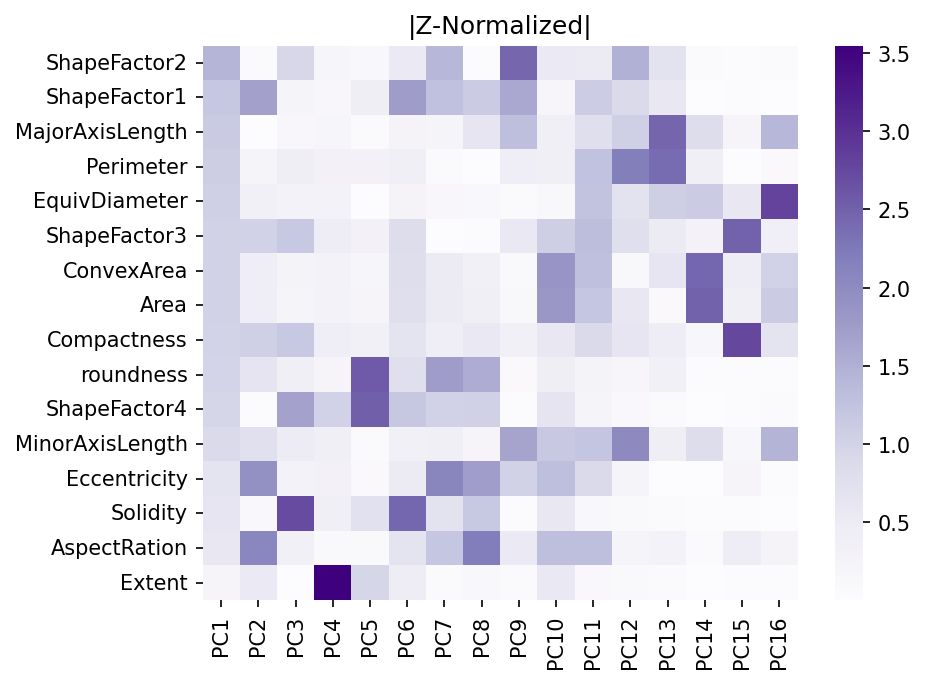

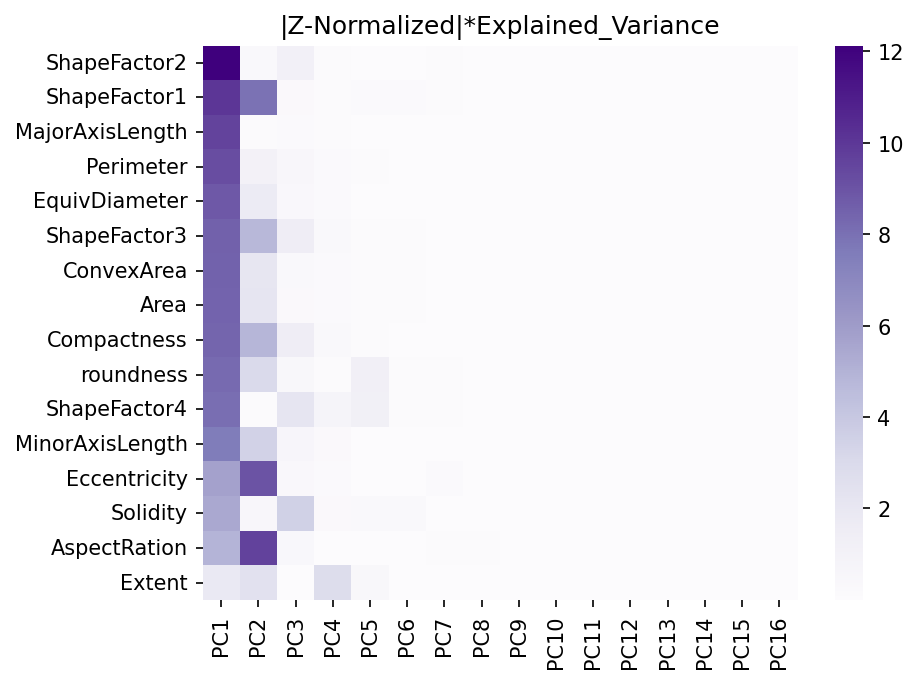

(                         PC1          PC2          PC3          PC4  \
 Area             8820.599073 -3567.524571  -225.032183  -135.540346   
 Perimeter        9467.171168 -2698.323726   -40.765730  -156.399204   
 MajorAxisLength  9829.607788 -1765.990992  -310.876598   -67.295480   
 MinorAxisLength  8000.225345 -4618.055141    34.861918  -197.329617   
 AspectRation     5675.549606  5879.664325  -864.807048   154.338395   
 Eccentricity     6390.488951  5393.213400  -813.464137   304.318452   
 ConvexArea       8838.129636 -3548.525087  -195.058975  -133.513285   
 EquivDiameter    9162.557829 -3240.312992  -166.038340  -133.592012   
 Extent           -364.174349 -3838.916348  -460.173399  2612.721819   
 Solidity        -3588.996635 -2292.170019 -3380.389537  -198.043023   
 roundness       -6037.679747 -4307.012478  -887.881524   234.443683   
 Compactness     -6201.129943 -5750.237644   764.447560  -241.132789   
 ShapeFactor1    -7656.499440  4514.624361  -239.883534   195.58

In [244]:
pca_feature_correlation(beans_scaled, result, pca.explained_variance_, beans_x.columns) 

In [253]:
pca_beans = PCA(n_components = 7, random_state=0)
pca_beans.set_output(transform="pandas")
result_pca_beans = pca_beans.fit_transform(beans_scaled)
eigenvalues_beans = pca_beans.explained_variance_

In [254]:
sum(pca_beans.explained_variance_ratio_ * 100)

99.59597525591064

## ICA

In [266]:
kurtosis_cars = []
kurtosis_cars_avg = []
for i in np.arange(2,len(cars_x.columns)+1):
    ica = FastICA(n_components=i, whiten='arbitrary-variance').set_output(transform="pandas")
    ica_cars = ica.fit_transform(cars_x)
    kurtosis_cars_avg.append(sp.stats.kurtosis(ica_cars).mean())
    kurtosis_cars.append(sp.stats.kurtosis(ica_cars))

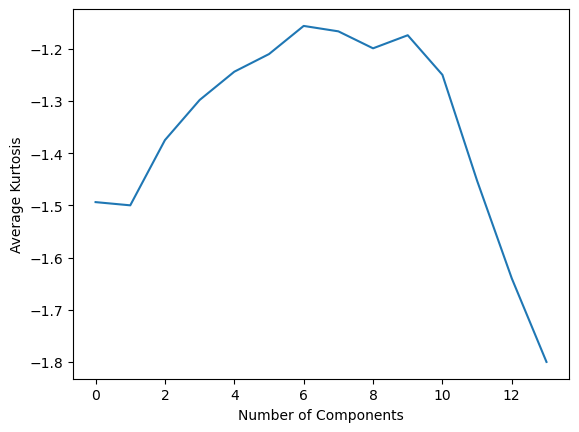

In [274]:
plt.plot(kurtosis_cars_avg)
plt.xlabel('Number of Components')
plt.ylabel('Average Kurtosis')
plt.show()

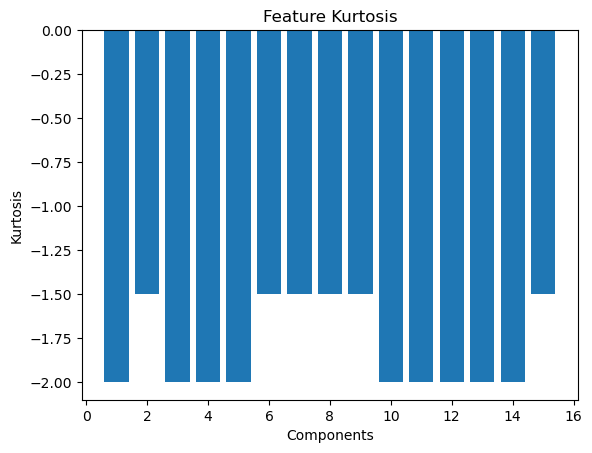

In [269]:
plt.bar(
    range(1,len(kurtosis_cars[13])+1),
    kurtosis_cars[13]
    )
 
 
plt.xlabel('Components')
plt.ylabel('Kurtosis')
plt.title('Feature Kurtosis')
plt.show()

In [280]:
# kurtosis is maximized at n = 6
ica_cars = FastICA(n_components=6, whiten='arbitrary-variance').set_output(transform="pandas")
ica_cars_result = ica_cars.fit_transform(cars_x)
ica_cars.get_feature_names_out(cars_x.columns)

array(['fastica0', 'fastica1', 'fastica2', 'fastica3', 'fastica4',
       'fastica5'], dtype=object)

In [271]:
kurtosis_beans = []
kurtosis_beans_avg = []
for i in np.arange(2,len(beans_x.columns)+1):
    ica = FastICA(n_components=i, whiten='arbitrary-variance').set_output(transform="pandas")
    ica_beans = ica.fit_transform(beans_x)
    kurtosis_beans_avg.append(sp.stats.kurtosis(ica_beans).mean())
    kurtosis_beans.append(sp.stats.kurtosis(ica_beans))

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


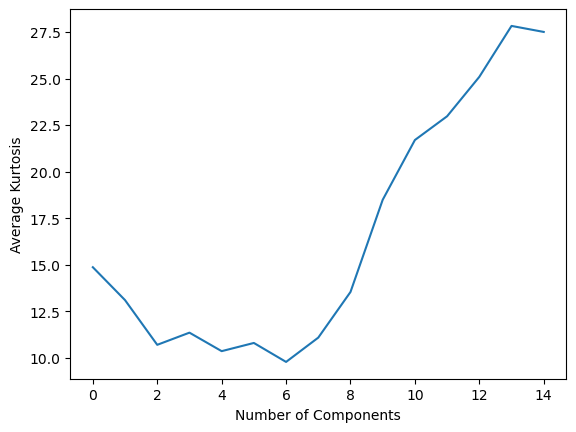

In [275]:
plt.plot(kurtosis_beans_avg)
plt.xlabel('Number of Components')
plt.ylabel('Average Kurtosis')
plt.show()

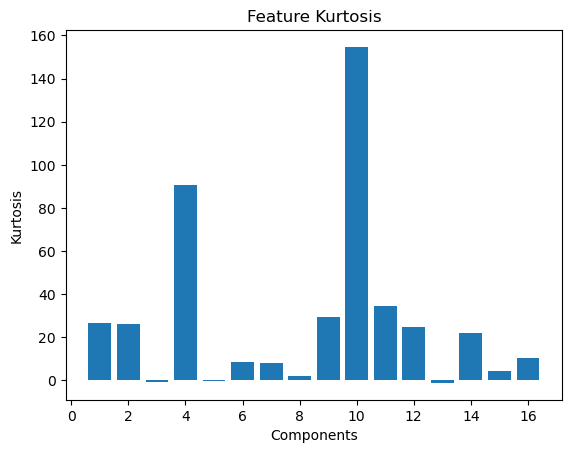

In [278]:
plt.bar(
    range(1,len(kurtosis_beans[14])+1),
    kurtosis_beans[14]
    )
 
 
plt.xlabel('Components')
plt.ylabel('Kurtosis')
plt.title('Feature Kurtosis')
plt.show()

In [328]:
ica_beans = FastICA(n_components=13, whiten='arbitrary-variance').set_output(transform="pandas")
ica_beans_result = ica_beans.fit_transform(beans_x)
ica_beans.get_feature_names_out(beans_x.columns)

array(['fastica0', 'fastica1', 'fastica2', 'fastica3', 'fastica4',
       'fastica5', 'fastica6', 'fastica7', 'fastica8', 'fastica9',
       'fastica10', 'fastica11', 'fastica12'], dtype=object)

## Random Projection

In [289]:
cars_rp_kurtosis = []
cars_rp_kurtosis_avg = []
for i in np.arange(2,len(cars_x.columns)+1):
    rp = GaussianRandomProjection(n_components=i, random_state=0).set_output(transform='pandas')
    cars_rp_data = rp.fit_transform(cars_x)
    cars_rp_kurtosis_avg.append(sp.stats.kurtosis(cars_rp_data).mean())
    cars_rp_kurtosis.append(sp.stats.kurtosis(cars_rp_data))

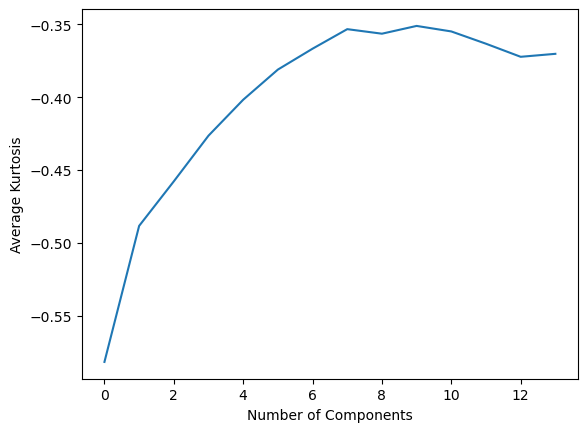

In [291]:
# n = 7 maximizes kurtosis

plt.plot(cars_rp_kurtosis_avg)
plt.xlabel('Number of Components')
plt.ylabel('Average Kurtosis')
plt.show()

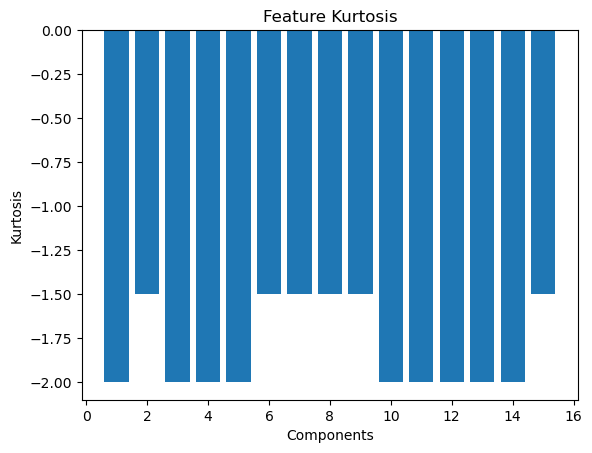

In [292]:
plt.bar(
    range(1,len(cars_rp_kurtosis[13])+1),
    kurtosis_cars[13]
    )
 
 
plt.xlabel('Components')
plt.ylabel('Kurtosis')
plt.title('Feature Kurtosis')
plt.show()

In [330]:
rp_cars = GaussianRandomProjection(n_components=7, random_state=0).set_output(transform="pandas")
rp_cars_result = rp_cars.fit_transform(cars_x)
rp_cars.get_feature_names_out(cars_x.columns)

array(['gaussianrandomprojection0', 'gaussianrandomprojection1',
       'gaussianrandomprojection2', 'gaussianrandomprojection3',
       'gaussianrandomprojection4', 'gaussianrandomprojection5',
       'gaussianrandomprojection6'], dtype=object)

In [293]:
beans_rp_kurtosis = []
beans_rp_kurtosis_avg = []
for i in np.arange(2,len(beans_x.columns)+1):
    rp = GaussianRandomProjection(n_components=i, random_state=0).set_output(transform='pandas')
    beans_rp_data = rp.fit_transform(beans_x)
    beans_rp_kurtosis_avg.append(sp.stats.kurtosis(beans_rp_data).mean())
    beans_rp_kurtosis.append(sp.stats.kurtosis(beans_rp_data))

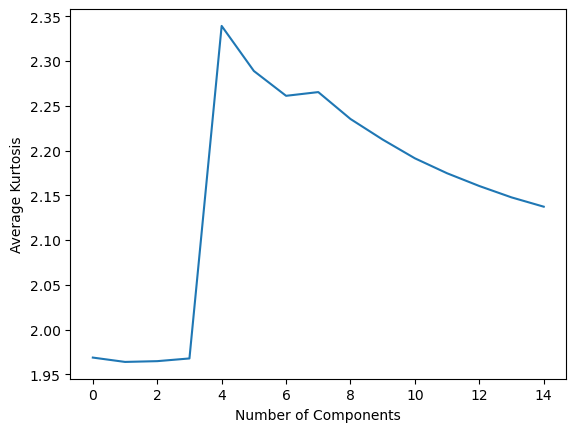

In [294]:
# n = 4 maximizes kurtosis

plt.plot(beans_rp_kurtosis_avg)
plt.xlabel('Number of Components')
plt.ylabel('Average Kurtosis')
plt.show()

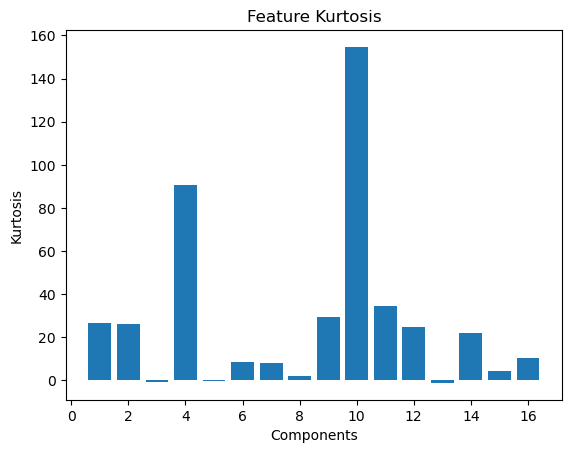

In [295]:
plt.bar(
    range(1,len(beans_rp_kurtosis[14])+1),
    kurtosis_beans[14]
    )
 
 
plt.xlabel('Components')
plt.ylabel('Kurtosis')
plt.title('Feature Kurtosis')
plt.show()

In [331]:
rp_beans = GaussianRandomProjection(n_components=4, random_state=0).set_output(transform="pandas")
rp_beans_result = rp_beans.fit_transform(beans_x)
rp_beans.get_feature_names_out(beans_x.columns)

array(['gaussianrandomprojection0', 'gaussianrandomprojection1',
       'gaussianrandomprojection2', 'gaussianrandomprojection3'],
      dtype=object)

## Single Value Decomposition

In [321]:
cars_scores = []
cars_times = []
for i in np.arange(2,len(cars_x.columns)+1):
    # define the pipeline
    t0 = time()
    steps = [('svd', TruncatedSVD(n_components=i,random_state=0)), ('m', DecisionTreeClassifier())]
    model = Pipeline(steps=steps)
    # evaluate model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, cars_x, cars_y, scoring='accuracy', cv=cv, n_jobs=-1)
    tot_time = time()-t0
    # report performance
    cars_scores.append(np.mean(n_scores))
    cars_times.append(tot_time)

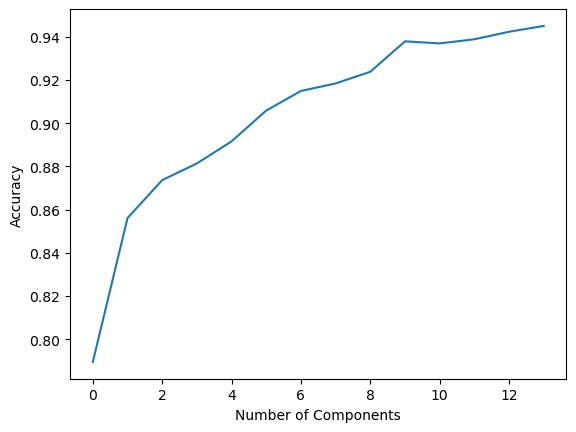

In [324]:
plt.plot(cars_scores)
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.show()

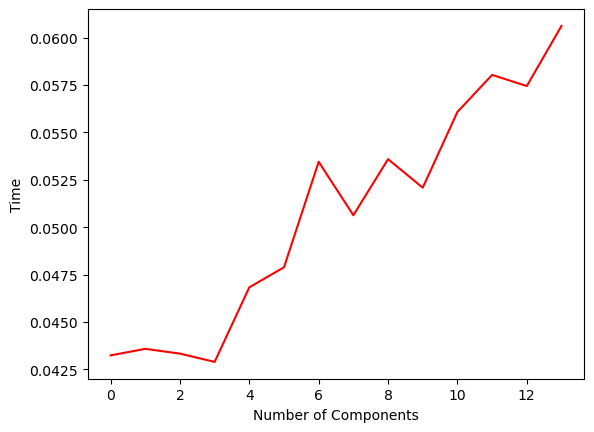

In [323]:
plt.plot(cars_times, color='r')
plt.xlabel('Number of Components')
plt.ylabel('Time')
plt.show()

In [347]:
svd_cars = TruncatedSVD(n_components=9,random_state=0).set_output(transform="pandas")
svd_cars_result = svd_cars.fit_transform(cars_x)
svd_cars.get_feature_names_out(cars_x.columns)

array(['truncatedsvd0', 'truncatedsvd1', 'truncatedsvd2', 'truncatedsvd3',
       'truncatedsvd4', 'truncatedsvd5', 'truncatedsvd6', 'truncatedsvd7',
       'truncatedsvd8'], dtype=object)

In [325]:
beans_scores = []
beans_times = []
for i in np.arange(2,len(beans_x.columns)+1):
    # define the pipeline
    t0 = time()
    steps = [('svd', TruncatedSVD(n_components=i,random_state=0)), ('m', DecisionTreeClassifier())]
    model = Pipeline(steps=steps)
    # evaluate model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, beans_x, beans_y, scoring='accuracy', cv=cv, n_jobs=-1)
    tot_time = time() - t0
    # report performance
    beans_scores.append(np.mean(n_scores))
    beans_times.append(tot_time)

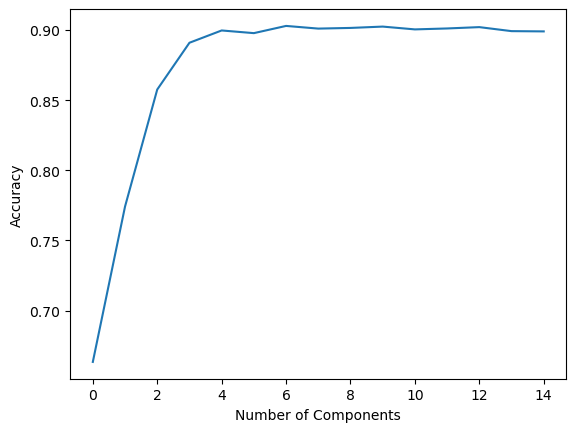

In [319]:
plt.plot(beans_scores)
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.show()

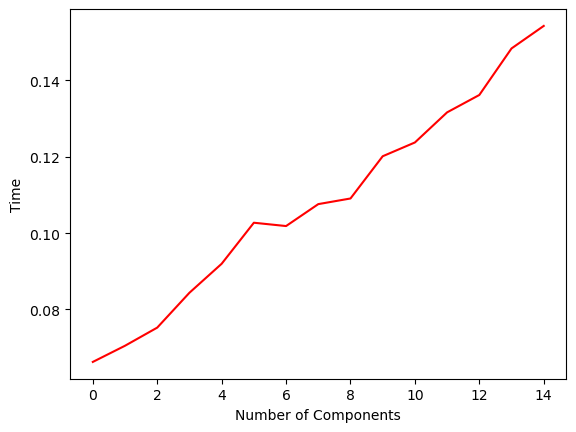

In [327]:
plt.plot(beans_times, color='r')
plt.xlabel('Number of Components')
plt.ylabel('Time')
plt.show()

In [348]:
svd_beans = TruncatedSVD(n_components=6,random_state=0).set_output(transform="pandas")
svd_beans_result = svd_beans.fit_transform(beans_x)
svd_beans.get_feature_names_out(beans_x.columns)

array(['truncatedsvd0', 'truncatedsvd1', 'truncatedsvd2', 'truncatedsvd3',
       'truncatedsvd4', 'truncatedsvd5'], dtype=object)

# Part 3: Dimenionality Reduction then Clustering

## Cars

In [332]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tinertia\tsilhouette\tch\tdb")
kmeans = KMeans(init="k-means++", n_clusters=n_digits_cars, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=result_pca_cars, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=3", data=result_pca_cars, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=4", data=result_pca_cars, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=5", data=result_pca_cars, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=n_digits_cars, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=result_pca_cars, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=result_pca_cars, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=result_pca_cars, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=5", data=result_pca_cars, labels=cars_y)

__________________________________________________________________________________
init		time	inertia	silhouette	ch	db
k-means++	0.027s	17871	0.062	110.133	3.925
n=3      	0.033s	16232	0.102	150.599	2.799
n=4      	0.032s	15284	0.094	146.925	2.578
n=5      	0.032s	14505	0.082	131.793	2.642
random   	0.261s	17283	0.037	73.295	4.462
random n=4	0.269s	15555	0.101	168.193	2.992
random n=4	0.266s	14883	0.097	147.295	2.798
random n=5	0.263s	14402	0.082	132.067	2.629


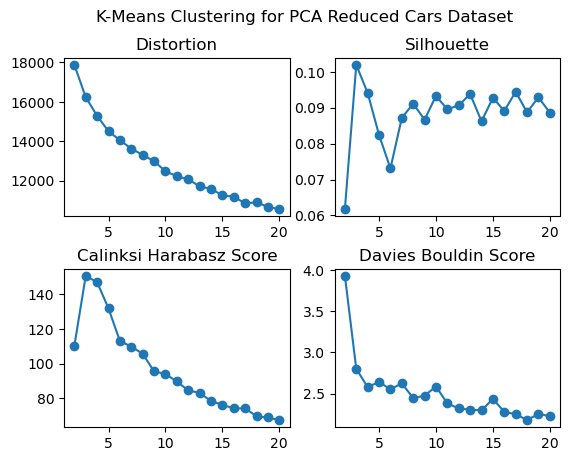

In [336]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(result_pca_cars)
    distortion.append(estimator[-1].inertia_)
    silhouette.append(metrics.silhouette_score(
        result_pca_cars,
        estimator[-1].labels_,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            result_pca_cars,
            estimator[-1].labels_
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            result_pca_cars,
            estimator[-1].labels_
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(2,2, hspace=0.33)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('K-Means Clustering for PCA Reduced Cars Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(2, 21), distortion, marker='o')
axs[0, 0].set_title('Distortion')
# axs[0, 0].set(xlabel='Number of clusters', ylabel='Distortion')
axs[0, 1].plot(range(2, 21), silhouette, marker='o')
axs[0, 1].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1, 0].plot(range(2, 21), ch, marker='o')
axs[1, 0].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[1, 1].plot(range(2, 21), db, marker='o')
axs[1, 1].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()


In [334]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tinertia\tsilhouette\tch\tdb")
kmeans = KMeans(init="k-means++", n_clusters=n_digits_cars, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=ica_cars_result, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=3", data=ica_cars_result, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=4", data=ica_cars_result, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=5", data=ica_cars_result, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=n_digits_cars, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=ica_cars_result, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=ica_cars_result, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=ica_cars_result, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=5", data=ica_cars_result, labels=cars_y)

__________________________________________________________________________________
init		time	inertia	silhouette	ch	db
k-means++	0.024s	9091	0.143	242.480	2.571
n=3      	0.029s	7874	0.170	273.120	1.975
n=4      	0.034s	7204	0.142	252.383	2.038
n=5      	0.030s	6540	0.136	252.103	1.724
random   	0.252s	8832	0.186	300.174	2.026
random n=4	0.267s	7701	0.184	298.738	1.877
random n=4	0.252s	6973	0.153	279.835	1.898
random n=5	0.255s	6399	0.149	267.132	1.697


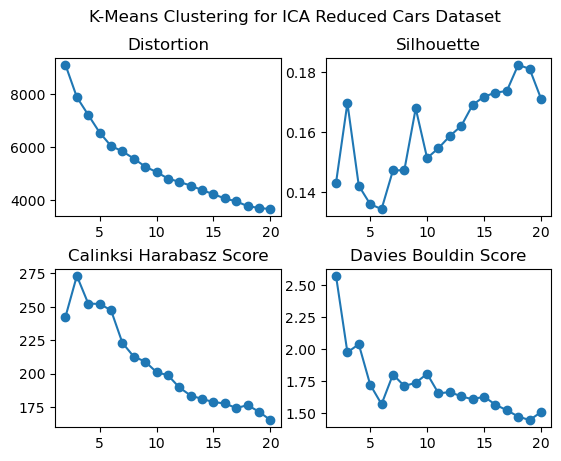

In [337]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(ica_cars_result)
    distortion.append(estimator[-1].inertia_)
    silhouette.append(metrics.silhouette_score(
        ica_cars_result,
        estimator[-1].labels_,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            ica_cars_result,
            estimator[-1].labels_
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            ica_cars_result,
            estimator[-1].labels_
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(2,2, hspace=0.33)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('K-Means Clustering for ICA Reduced Cars Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(2, 21), distortion, marker='o')
axs[0, 0].set_title('Distortion')
# axs[0, 0].set(xlabel='Number of clusters', ylabel='Distortion')
axs[0, 1].plot(range(2, 21), silhouette, marker='o')
axs[0, 1].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1, 0].plot(range(2, 21), ch, marker='o')
axs[1, 0].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[1, 1].plot(range(2, 21), db, marker='o')
axs[1, 1].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()


In [338]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tinertia\tsilhouette\tch\tdb")
kmeans = KMeans(init="k-means++", n_clusters=n_digits_cars, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=rp_cars_result, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=3", data=rp_cars_result, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=4", data=rp_cars_result, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=5", data=rp_cars_result, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=n_digits_cars, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=rp_cars_result, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=rp_cars_result, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=rp_cars_result, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=5", data=rp_cars_result, labels=cars_y)

__________________________________________________________________________________
init		time	inertia	silhouette	ch	db
k-means++	0.026s	9718	0.170	388.599	2.036
n=3      	0.033s	8435	0.160	384.635	1.718
n=4      	0.034s	7534	0.155	346.717	1.735
n=5      	0.038s	6955	0.151	325.616	1.670
random   	0.276s	9718	0.170	388.599	2.036
random n=4	0.284s	8299	0.159	354.073	1.825
random n=4	0.288s	7523	0.156	352.834	1.724
random n=5	0.284s	6962	0.149	320.733	1.695


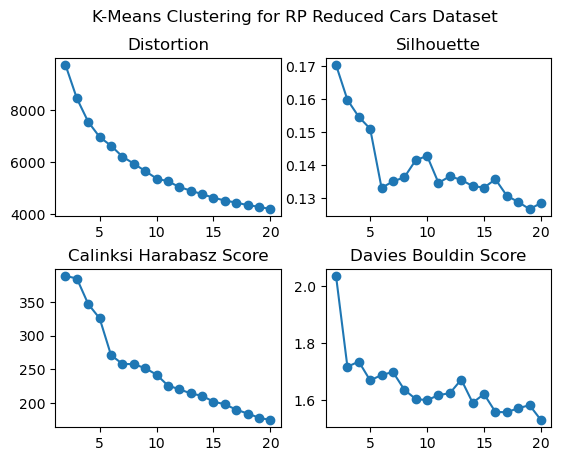

In [340]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(rp_cars_result)
    distortion.append(estimator[-1].inertia_)
    silhouette.append(metrics.silhouette_score(
        rp_cars_result,
        estimator[-1].labels_,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            rp_cars_result,
            estimator[-1].labels_
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            rp_cars_result,
            estimator[-1].labels_
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(2,2, hspace=0.33)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('K-Means Clustering for RP Reduced Cars Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(2, 21), distortion, marker='o')
axs[0, 0].set_title('Distortion')
# axs[0, 0].set(xlabel='Number of clusters', ylabel='Distortion')
axs[0, 1].plot(range(2, 21), silhouette, marker='o')
axs[0, 1].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1, 0].plot(range(2, 21), ch, marker='o')
axs[1, 0].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[1, 1].plot(range(2, 21), db, marker='o')
axs[1, 1].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [349]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tinertia\tsilhouette\tch\tdb")
kmeans = KMeans(init="k-means++", n_clusters=n_digits_cars, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=svd_cars_result, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=3", data=svd_cars_result, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=4", data=svd_cars_result, labels=cars_y)

kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=5", data=svd_cars_result, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=n_digits_cars, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=svd_cars_result, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=svd_cars_result, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=svd_cars_result, labels=cars_y)

kmeans = KMeans(init="random", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=5", data=svd_cars_result, labels=cars_y)

__________________________________________________________________________________
init		time	inertia	silhouette	ch	db
k-means++	0.025s	14397	0.086	137.318	3.359
n=3      	0.034s	12663	0.128	184.384	2.570
n=4      	0.032s	11940	0.062	140.887	3.065
n=5      	0.033s	11167	0.107	157.335	2.293
random   	0.277s	14000	0.121	181.638	2.633
random n=4	0.275s	12650	0.127	185.669	2.551
random n=4	0.274s	11834	0.120	168.933	2.438
random n=5	0.269s	11128	0.117	159.699	2.273


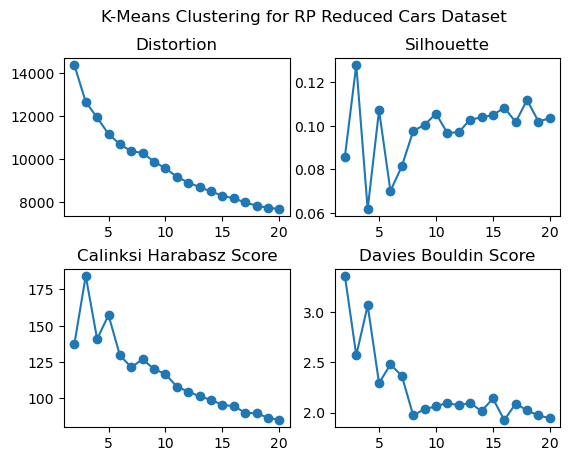

In [350]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(svd_cars_result)
    distortion.append(estimator[-1].inertia_)
    silhouette.append(metrics.silhouette_score(
        svd_cars_result,
        estimator[-1].labels_,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            svd_cars_result,
            estimator[-1].labels_
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            svd_cars_result,
            estimator[-1].labels_
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(2,2, hspace=0.33)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('K-Means Clustering for RP Reduced Cars Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(2, 21), distortion, marker='o')
axs[0, 0].set_title('Distortion')
# axs[0, 0].set(xlabel='Number of clusters', ylabel='Distortion')
axs[0, 1].plot(range(2, 21), silhouette, marker='o')
axs[0, 1].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1, 0].plot(range(2, 21), ch, marker='o')
axs[1, 0].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[1, 1].plot(range(2, 21), db, marker='o')
axs[1, 1].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [341]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tsilhouette\tch\tdb")

gm = GaussianMixture(n_components=n_digits_cars, random_state=0)
bench_gm(gm=gm, name="Gaussian 2", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0)
bench_gm(gm=gm, name="Gaussian 3", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0)
bench_gm(gm=gm, name="Gaussian 4", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0)
bench_gm(gm=gm, name="Gaussian 5", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0)
bench_gm(gm=gm, name="Gaussian 6", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=n_digits_cars, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 2 ++", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 3 ++", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 4 ++", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 5 ++", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 6 ++", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=n_digits_cars, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 2 random", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 3 random", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 4 random", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 5 random", data=result_pca_cars, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 6 random", data=result_pca_cars, labels=cars_y)

__________________________________________________________________________________
init		time	silhouette	ch	db
Gaussian 2	0.038s	0.063	112.565	3.891
Gaussian 3	0.044s	0.105	153.952	2.865
Gaussian 4	0.038s	0.094	146.925	2.578
Gaussian 5	0.036s	0.082	131.793	2.642
Gaussian 6	0.040s	0.073	112.989	2.551
Gaussian 2 ++	0.018s	0.063	112.565	3.891
Gaussian 3 ++	0.016s	0.069	114.075	3.396
Gaussian 4 ++	0.030s	0.076	120.971	2.738
Gaussian 5 ++	0.023s	0.053	88.223	4.231
Gaussian 6 ++	0.019s	0.059	100.538	2.895
Gaussian 2 random	0.004s	0.050	85.590	4.451
Gaussian 3 random	0.015s	0.057	87.219	3.760
Gaussian 4 random	0.030s	0.028	72.792	3.608
Gaussian 5 random	0.038s	0.028	79.383	3.097
Gaussian 6 random	0.034s	0.013	64.700	3.173


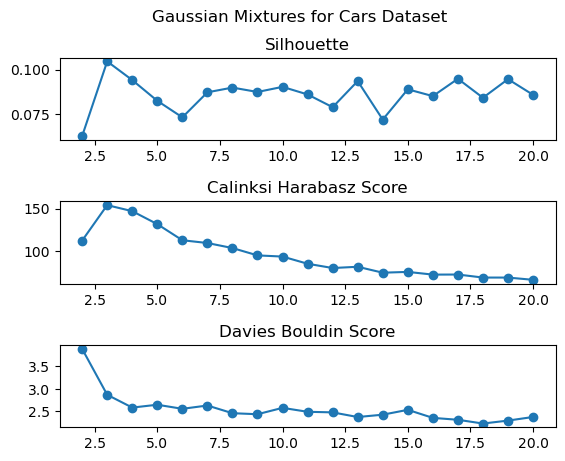

In [342]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    # kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    gm = GaussianMixture(n_components=i, random_state=0)
    results = make_pipeline(StandardScaler(), gm).fit_predict(result_pca_cars)
    silhouette.append(metrics.silhouette_score(
        result_pca_cars,
        results,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            result_pca_cars,
            results
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            result_pca_cars,
            results
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0.75)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('Gaussian Mixtures for Cars Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0].plot(range(2, 21), silhouette, marker='o')
axs[0].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1].plot(range(2, 21), ch, marker='o')
axs[1].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[2].plot(range(2, 21), db, marker='o')
axs[2].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [343]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tsilhouette\tch\tdb")

gm = GaussianMixture(n_components=n_digits_cars, random_state=0)
bench_gm(gm=gm, name="Gaussian 2", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0)
bench_gm(gm=gm, name="Gaussian 3", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0)
bench_gm(gm=gm, name="Gaussian 4", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0)
bench_gm(gm=gm, name="Gaussian 5", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0)
bench_gm(gm=gm, name="Gaussian 6", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=n_digits_cars, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 2 ++", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 3 ++", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 4 ++", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 5 ++", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 6 ++", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=n_digits_cars, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 2 random", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 3 random", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 4 random", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 5 random", data=ica_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 6 random", data=ica_cars_result, labels=cars_y)

__________________________________________________________________________________
init		time	silhouette	ch	db
Gaussian 2	0.039s	0.129	221.824	2.747
Gaussian 3	0.036s	0.169	280.174	1.965
Gaussian 4	0.054s	0.171	282.244	1.773
Gaussian 5	0.066s	0.139	244.292	1.744
Gaussian 6	0.062s	0.123	224.142	1.632
Gaussian 2 ++	0.023s	0.182	293.848	2.049
Gaussian 3 ++	0.017s	0.169	280.174	1.965
Gaussian 4 ++	0.029s	0.129	249.446	2.126
Gaussian 5 ++	0.032s	-0.014	121.121	2.862
Gaussian 6 ++	0.028s	0.085	159.326	1.973
Gaussian 2 random	0.004s	0.064	97.682	4.105
Gaussian 3 random	0.005s	0.032	49.639	6.884
Gaussian 4 random	0.005s	0.064	111.491	3.245
Gaussian 5 random	0.005s	0.040	62.753	4.552
Gaussian 6 random	0.006s	0.087	133.193	2.385


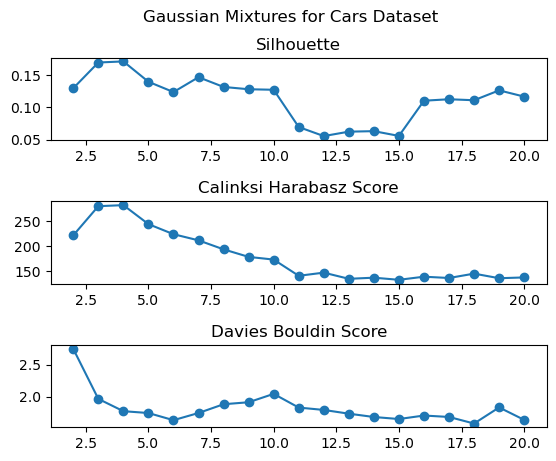

In [344]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    # kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    gm = GaussianMixture(n_components=i, random_state=0)
    results = make_pipeline(StandardScaler(), gm).fit_predict(ica_cars_result)
    silhouette.append(metrics.silhouette_score(
        ica_cars_result,
        results,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            ica_cars_result,
            results
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            ica_cars_result,
            results
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0.75)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('Gaussian Mixtures for Cars Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0].plot(range(2, 21), silhouette, marker='o')
axs[0].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1].plot(range(2, 21), ch, marker='o')
axs[1].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[2].plot(range(2, 21), db, marker='o')
axs[2].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [345]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tsilhouette\tch\tdb")

gm = GaussianMixture(n_components=n_digits_cars, random_state=0)
bench_gm(gm=gm, name="Gaussian 2", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0)
bench_gm(gm=gm, name="Gaussian 3", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0)
bench_gm(gm=gm, name="Gaussian 4", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0)
bench_gm(gm=gm, name="Gaussian 5", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0)
bench_gm(gm=gm, name="Gaussian 6", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=n_digits_cars, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 2 ++", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 3 ++", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 4 ++", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 5 ++", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 6 ++", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=n_digits_cars, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 2 random", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 3 random", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 4 random", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 5 random", data=rp_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 6 random", data=rp_cars_result, labels=cars_y)

__________________________________________________________________________________
init		time	silhouette	ch	db
Gaussian 2	0.062s	0.127	253.494	2.477
Gaussian 3	0.064s	0.106	212.734	2.032
Gaussian 4	0.076s	0.080	193.258	2.320
Gaussian 5	0.082s	0.083	212.824	1.916
Gaussian 6	0.080s	0.061	160.657	2.293
Gaussian 2 ++	0.031s	0.093	170.118	3.024
Gaussian 3 ++	0.031s	0.084	170.100	2.553
Gaussian 4 ++	0.024s	0.062	153.676	2.433
Gaussian 5 ++	0.041s	0.040	130.600	2.505
Gaussian 6 ++	0.084s	0.035	118.027	2.981
Gaussian 2 random	0.005s	0.079	138.322	3.402
Gaussian 3 random	0.005s	0.056	133.895	3.238
Gaussian 4 random	0.007s	0.040	87.261	4.559
Gaussian 5 random	0.006s	0.002	63.992	3.834
Gaussian 6 random	0.006s	0.010	80.342	3.883


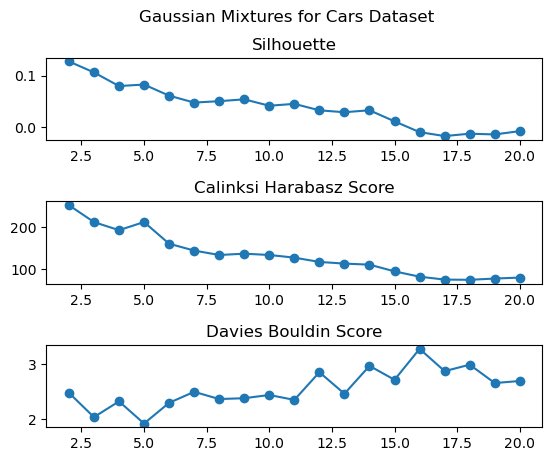

In [346]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    # kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    gm = GaussianMixture(n_components=i, random_state=0)
    results = make_pipeline(StandardScaler(), gm).fit_predict(rp_cars_result)
    silhouette.append(metrics.silhouette_score(
        rp_cars_result,
        results,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            rp_cars_result,
            results
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            rp_cars_result,
            results
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0.75)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('Gaussian Mixtures for Cars Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0].plot(range(2, 21), silhouette, marker='o')
axs[0].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1].plot(range(2, 21), ch, marker='o')
axs[1].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[2].plot(range(2, 21), db, marker='o')
axs[2].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [351]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tsilhouette\tch\tdb")

gm = GaussianMixture(n_components=n_digits_cars, random_state=0)
bench_gm(gm=gm, name="Gaussian 2", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0)
bench_gm(gm=gm, name="Gaussian 3", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0)
bench_gm(gm=gm, name="Gaussian 4", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0)
bench_gm(gm=gm, name="Gaussian 5", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0)
bench_gm(gm=gm, name="Gaussian 6", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=n_digits_cars, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 2 ++", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 3 ++", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 4 ++", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 5 ++", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 6 ++", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=n_digits_cars, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 2 random", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 3 random", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 4 random", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 5 random", data=svd_cars_result, labels=cars_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 6 random", data=svd_cars_result, labels=cars_y)

__________________________________________________________________________________
init		time	silhouette	ch	db
Gaussian 2	0.037s	0.085	151.367	3.342
Gaussian 3	0.036s	0.128	184.723	2.561
Gaussian 4	0.055s	0.053	141.005	3.386
Gaussian 5	0.041s	0.107	157.536	2.298
Gaussian 6	0.050s	-0.011	126.667	2.159
Gaussian 2 ++	0.022s	0.074	133.654	3.561
Gaussian 3 ++	0.014s	0.128	184.723	2.561
Gaussian 4 ++	0.023s	0.095	144.457	2.668
Gaussian 5 ++	0.024s	0.104	140.207	2.692
Gaussian 6 ++	0.023s	0.095	128.562	2.385
Gaussian 2 random	0.004s	0.055	94.837	4.223
Gaussian 3 random	0.022s	0.068	103.082	3.448
Gaussian 4 random	0.028s	0.046	88.784	3.441
Gaussian 5 random	0.029s	0.052	97.379	3.286
Gaussian 6 random	0.046s	0.037	93.426	3.162


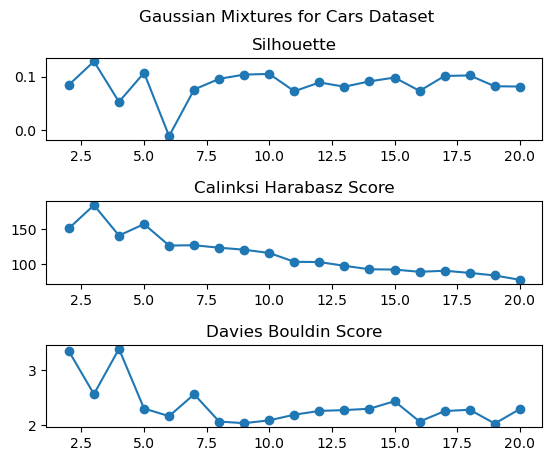

In [352]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    # kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    gm = GaussianMixture(n_components=i, random_state=0)
    results = make_pipeline(StandardScaler(), gm).fit_predict(svd_cars_result)
    silhouette.append(metrics.silhouette_score(
        svd_cars_result,
        results,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            svd_cars_result,
            results
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            svd_cars_result,
            results
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0.75)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('Gaussian Mixtures for Cars Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0].plot(range(2, 21), silhouette, marker='o')
axs[0].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1].plot(range(2, 21), ch, marker='o')
axs[1].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[2].plot(range(2, 21), db, marker='o')
axs[2].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

## Beans

In [353]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tinertia\tsilhouette\tch\tdb")
kmeans = KMeans(init="k-means++", n_clusters=n_digits_beans, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=result_pca_beans, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=3", data=result_pca_beans, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=4", data=result_pca_beans, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=5", data=result_pca_beans, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=n_digits_beans, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=result_pca_beans, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=result_pca_beans, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=result_pca_beans, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=5", data=result_pca_beans, labels=beans_y)

__________________________________________________________________________________
init		time	inertia	silhouette	ch	db
k-means++	0.035s	11485	0.308	1787.237	1.139
n=3      	0.037s	18606	0.389	2668.668	0.964
n=4      	0.026s	16346	0.315	2103.676	1.242
n=5      	0.028s	14602	0.234	1414.386	1.679
random   	0.283s	11432	0.279	1745.197	1.199
random n=4	0.272s	18800	0.288	1705.992	1.287
random n=4	0.272s	16346	0.316	2104.895	1.241
random n=5	0.252s	14393	0.277	1785.611	1.364


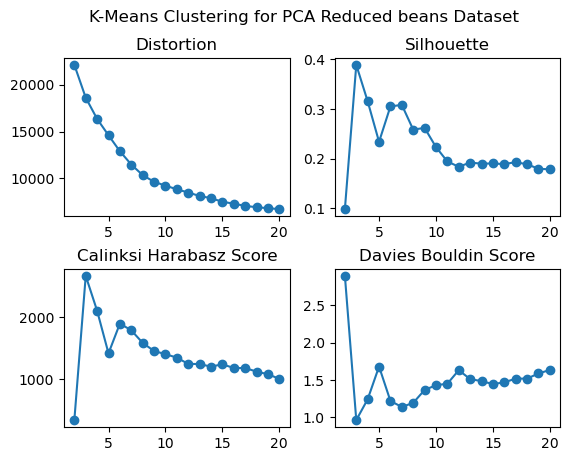

In [354]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(result_pca_beans)
    distortion.append(estimator[-1].inertia_)
    silhouette.append(metrics.silhouette_score(
        result_pca_beans,
        estimator[-1].labels_,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            result_pca_beans,
            estimator[-1].labels_
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            result_pca_beans,
            estimator[-1].labels_
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(2,2, hspace=0.33)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('K-Means Clustering for PCA Reduced beans Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(2, 21), distortion, marker='o')
axs[0, 0].set_title('Distortion')
# axs[0, 0].set(xlabel='Number of clusters', ylabel='Distortion')
axs[0, 1].plot(range(2, 21), silhouette, marker='o')
axs[0, 1].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1, 0].plot(range(2, 21), ch, marker='o')
axs[1, 0].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[1, 1].plot(range(2, 21), db, marker='o')
axs[1, 1].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()


In [355]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tinertia\tsilhouette\tch\tdb")
kmeans = KMeans(init="k-means++", n_clusters=n_digits_beans, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=ica_beans_result, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=3", data=ica_beans_result, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=4", data=ica_beans_result, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=5", data=ica_beans_result, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=n_digits_beans, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=ica_beans_result, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=ica_beans_result, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=ica_beans_result, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=5", data=ica_beans_result, labels=beans_y)

__________________________________________________________________________________
init		time	inertia	silhouette	ch	db
k-means++	0.031s	30438	0.135	288.078	1.845
n=3      	0.034s	39964	0.069	242.230	2.680
n=4      	0.026s	37032	0.088	266.469	2.435
n=5      	0.026s	35001	0.108	262.095	2.265
random   	0.276s	30342	0.159	290.846	1.808
random n=4	0.254s	39495	0.136	265.847	2.331
random n=4	0.276s	36756	0.115	277.223	2.374
random n=5	0.281s	34423	0.123	281.163	2.145


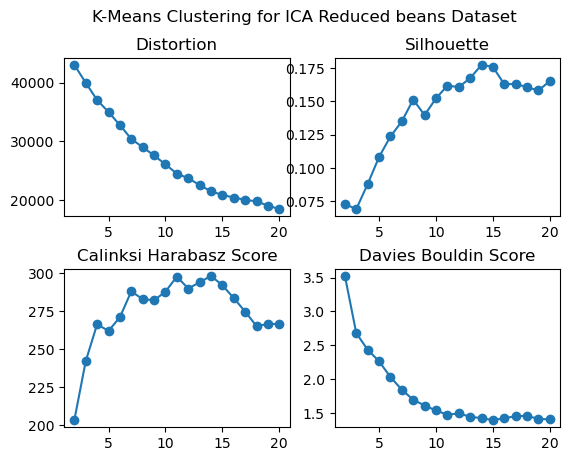

In [356]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(ica_beans_result)
    distortion.append(estimator[-1].inertia_)
    silhouette.append(metrics.silhouette_score(
        ica_beans_result,
        estimator[-1].labels_,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            ica_beans_result,
            estimator[-1].labels_
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            ica_beans_result,
            estimator[-1].labels_
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(2,2, hspace=0.33)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('K-Means Clustering for ICA Reduced beans Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(2, 21), distortion, marker='o')
axs[0, 0].set_title('Distortion')
# axs[0, 0].set(xlabel='Number of clusters', ylabel='Distortion')
axs[0, 1].plot(range(2, 21), silhouette, marker='o')
axs[0, 1].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1, 0].plot(range(2, 21), ch, marker='o')
axs[1, 0].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[1, 1].plot(range(2, 21), db, marker='o')
axs[1, 1].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()


In [357]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tinertia\tsilhouette\tch\tdb")
kmeans = KMeans(init="k-means++", n_clusters=n_digits_beans, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=rp_beans_result, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=3", data=rp_beans_result, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=4", data=rp_beans_result, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=5", data=rp_beans_result, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=n_digits_beans, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=rp_beans_result, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=rp_beans_result, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=rp_beans_result, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=5", data=rp_beans_result, labels=beans_y)

__________________________________________________________________________________
init		time	inertia	silhouette	ch	db
k-means++	0.030s	234	0.532	34311.518	0.576
n=3      	0.028s	914	0.669	25036.681	0.389
n=4      	0.026s	602	0.643	25949.062	0.538
n=5      	0.031s	507	0.643	23290.723	0.514
random   	0.274s	234	0.533	34298.321	0.576
random n=4	0.246s	914	0.669	25037.637	0.390
random n=4	0.252s	602	0.643	25949.596	0.537
random n=5	0.251s	411	0.563	28924.272	0.573


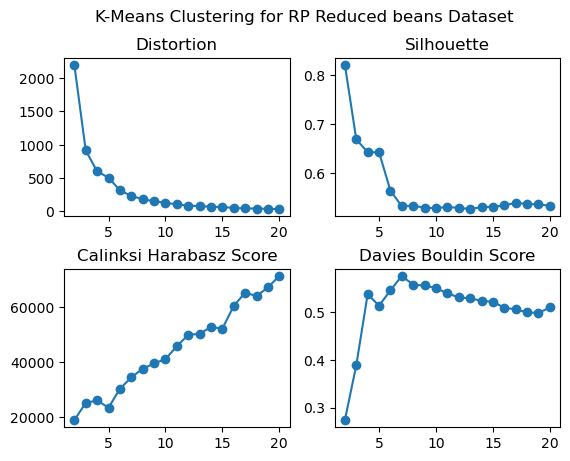

In [358]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(rp_beans_result)
    distortion.append(estimator[-1].inertia_)
    silhouette.append(metrics.silhouette_score(
        rp_beans_result,
        estimator[-1].labels_,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            rp_beans_result,
            estimator[-1].labels_
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            rp_beans_result,
            estimator[-1].labels_
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(2,2, hspace=0.33)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('K-Means Clustering for RP Reduced beans Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(2, 21), distortion, marker='o')
axs[0, 0].set_title('Distortion')
# axs[0, 0].set(xlabel='Number of clusters', ylabel='Distortion')
axs[0, 1].plot(range(2, 21), silhouette, marker='o')
axs[0, 1].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1, 0].plot(range(2, 21), ch, marker='o')
axs[1, 0].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[1, 1].plot(range(2, 21), db, marker='o')
axs[1, 1].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [359]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tinertia\tsilhouette\tch\tdb")
kmeans = KMeans(init="k-means++", n_clusters=n_digits_beans, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=svd_beans_result, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=3", data=svd_beans_result, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=4", data=svd_beans_result, labels=beans_y)

kmeans = KMeans(init="k-means++", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="n=5", data=svd_beans_result, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=n_digits_beans, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=svd_beans_result, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=3, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=svd_beans_result, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=4, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=4", data=svd_beans_result, labels=beans_y)

kmeans = KMeans(init="random", n_clusters=5, n_init='auto', random_state=0)
bench_k_means(kmeans=kmeans, name="random n=5", data=svd_beans_result, labels=beans_y)

__________________________________________________________________________________
init		time	inertia	silhouette	ch	db
k-means++	0.027s	5748	-0.134	4271.777	3.968
n=3      	0.035s	12551	0.330	11953.474	0.956
n=4      	0.025s	10020	0.214	8314.523	1.440
n=5      	0.029s	7963	-0.044	5958.590	1.804
random   	0.258s	5745	-0.147	4320.396	3.603
random n=4	0.249s	12428	0.302	10897.836	0.799
random n=4	0.253s	10020	0.214	8314.523	1.440
random n=5	0.257s	7963	-0.044	5955.087	1.809


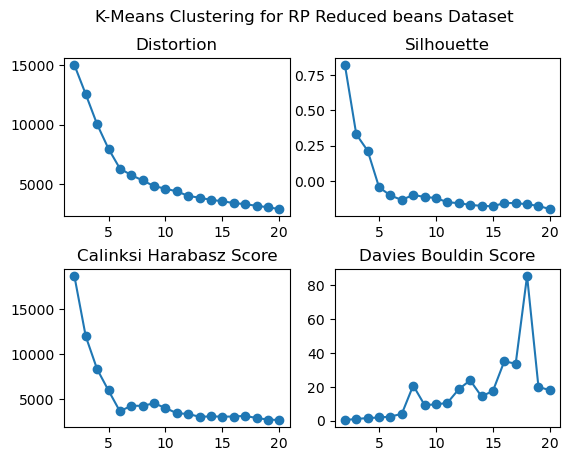

In [360]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    estimator = make_pipeline(StandardScaler(), kmeans).fit(svd_beans_result)
    distortion.append(estimator[-1].inertia_)
    silhouette.append(metrics.silhouette_score(
        svd_beans_result,
        estimator[-1].labels_,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            svd_beans_result,
            estimator[-1].labels_
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            svd_beans_result,
            estimator[-1].labels_
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(2,2, hspace=0.33)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('K-Means Clustering for RP Reduced beans Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(2, 21), distortion, marker='o')
axs[0, 0].set_title('Distortion')
# axs[0, 0].set(xlabel='Number of clusters', ylabel='Distortion')
axs[0, 1].plot(range(2, 21), silhouette, marker='o')
axs[0, 1].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1, 0].plot(range(2, 21), ch, marker='o')
axs[1, 0].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[1, 1].plot(range(2, 21), db, marker='o')
axs[1, 1].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [361]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tsilhouette\tch\tdb")

gm = GaussianMixture(n_components=n_digits_beans, random_state=0)
bench_gm(gm=gm, name="Gaussian 2", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0)
bench_gm(gm=gm, name="Gaussian 3", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0)
bench_gm(gm=gm, name="Gaussian 4", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0)
bench_gm(gm=gm, name="Gaussian 5", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0)
bench_gm(gm=gm, name="Gaussian 6", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=n_digits_beans, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 2 ++", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 3 ++", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 4 ++", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 5 ++", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 6 ++", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=n_digits_beans, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 2 random", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 3 random", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 4 random", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 5 random", data=result_pca_beans, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 6 random", data=result_pca_beans, labels=beans_y)

__________________________________________________________________________________
init		time	silhouette	ch	db
Gaussian 2	0.149s	0.308	1801.658	1.422
Gaussian 3	0.040s	0.390	2673.830	0.970
Gaussian 4	0.042s	0.318	2160.420	1.221
Gaussian 5	0.113s	0.292	1819.630	1.442
Gaussian 6	0.067s	0.343	2110.628	1.238
Gaussian 2 ++	0.063s	0.310	1801.714	1.389
Gaussian 3 ++	0.042s	0.353	2280.982	1.073
Gaussian 4 ++	0.045s	0.318	2167.849	1.412
Gaussian 5 ++	0.056s	0.326	2208.548	1.234
Gaussian 6 ++	0.105s	0.332	2086.968	1.255
Gaussian 2 random	0.111s	0.258	1543.164	1.778
Gaussian 3 random	0.037s	0.304	1955.307	1.256
Gaussian 4 random	0.071s	0.274	1930.168	1.842
Gaussian 5 random	0.065s	0.331	2168.323	1.144
Gaussian 6 random	0.066s	0.327	2110.347	1.240


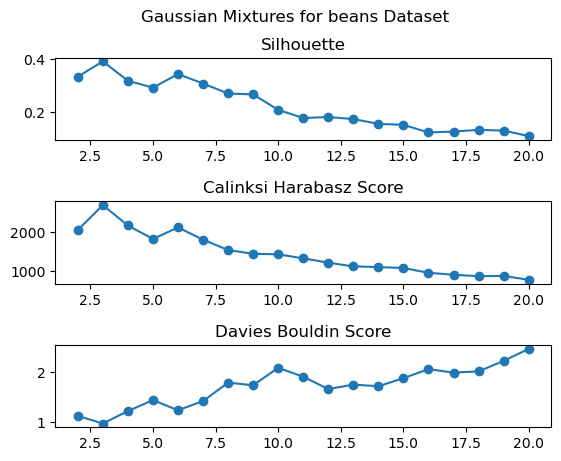

In [362]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    # kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    gm = GaussianMixture(n_components=i, random_state=0)
    results = make_pipeline(StandardScaler(), gm).fit_predict(result_pca_beans)
    silhouette.append(metrics.silhouette_score(
        result_pca_beans,
        results,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            result_pca_beans,
            results
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            result_pca_beans,
            results
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0.75)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('Gaussian Mixtures for beans Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0].plot(range(2, 21), silhouette, marker='o')
axs[0].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1].plot(range(2, 21), ch, marker='o')
axs[1].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[2].plot(range(2, 21), db, marker='o')
axs[2].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [363]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tsilhouette\tch\tdb")

gm = GaussianMixture(n_components=n_digits_beans, random_state=0)
bench_gm(gm=gm, name="Gaussian 2", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0)
bench_gm(gm=gm, name="Gaussian 3", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0)
bench_gm(gm=gm, name="Gaussian 4", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0)
bench_gm(gm=gm, name="Gaussian 5", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0)
bench_gm(gm=gm, name="Gaussian 6", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=n_digits_beans, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 2 ++", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 3 ++", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 4 ++", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 5 ++", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 6 ++", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=n_digits_beans, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 2 random", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 3 random", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 4 random", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 5 random", data=ica_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 6 random", data=ica_beans_result, labels=beans_y)

__________________________________________________________________________________
init		time	silhouette	ch	db
Gaussian 2	0.219s	0.122	219.667	2.916
Gaussian 3	0.087s	0.084	235.598	3.094
Gaussian 4	0.130s	0.080	258.240	2.471
Gaussian 5	0.123s	0.115	275.173	2.163
Gaussian 6	0.084s	0.134	276.231	1.985
Gaussian 2 ++	0.171s	0.115	216.418	2.523
Gaussian 3 ++	0.091s	0.096	266.744	2.760
Gaussian 4 ++	0.060s	0.091	227.348	3.028
Gaussian 5 ++	0.084s	0.086	201.655	3.083
Gaussian 6 ++	0.098s	0.101	235.692	2.610
Gaussian 2 random	0.100s	0.111	210.772	2.779
Gaussian 3 random	0.045s	0.102	267.331	2.759
Gaussian 4 random	0.113s	0.073	189.044	3.149
Gaussian 5 random	0.057s	0.109	256.972	2.266
Gaussian 6 random	0.155s	0.095	194.809	2.860


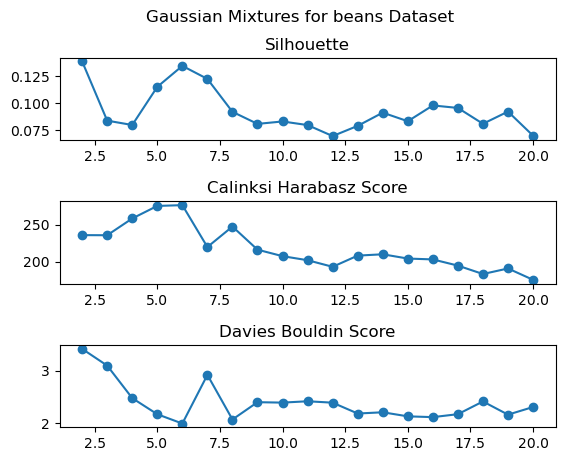

In [364]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    # kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    gm = GaussianMixture(n_components=i, random_state=0)
    results = make_pipeline(StandardScaler(), gm).fit_predict(ica_beans_result)
    silhouette.append(metrics.silhouette_score(
        ica_beans_result,
        results,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            ica_beans_result,
            results
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            ica_beans_result,
            results
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0.75)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('Gaussian Mixtures for beans Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0].plot(range(2, 21), silhouette, marker='o')
axs[0].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1].plot(range(2, 21), ch, marker='o')
axs[1].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[2].plot(range(2, 21), db, marker='o')
axs[2].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [365]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tsilhouette\tch\tdb")

gm = GaussianMixture(n_components=n_digits_beans, random_state=0)
bench_gm(gm=gm, name="Gaussian 2", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0)
bench_gm(gm=gm, name="Gaussian 3", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0)
bench_gm(gm=gm, name="Gaussian 4", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0)
bench_gm(gm=gm, name="Gaussian 5", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0)
bench_gm(gm=gm, name="Gaussian 6", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=n_digits_beans, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 2 ++", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 3 ++", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 4 ++", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 5 ++", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 6 ++", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=n_digits_beans, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 2 random", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 3 random", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 4 random", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 5 random", data=rp_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 6 random", data=rp_beans_result, labels=beans_y)

__________________________________________________________________________________
init		time	silhouette	ch	db
Gaussian 2	0.067s	0.367	13411.056	1.412
Gaussian 3	0.034s	0.645	23290.610	0.401
Gaussian 4	0.039s	0.577	17931.489	0.925
Gaussian 5	0.052s	0.568	16022.195	1.069
Gaussian 6	0.055s	0.417	15253.588	1.119
Gaussian 2 ++	0.035s	0.382	15057.198	1.201
Gaussian 3 ++	0.013s	0.644	23266.148	0.401
Gaussian 4 ++	0.020s	0.574	18193.389	0.935
Gaussian 5 ++	0.029s	0.576	16910.289	0.976
Gaussian 6 ++	0.030s	0.492	13622.794	1.389
Gaussian 2 random	0.049s	0.312	9442.866	3.578
Gaussian 3 random	0.024s	0.642	23129.443	0.401
Gaussian 4 random	0.031s	0.495	17450.000	0.606
Gaussian 5 random	0.035s	0.390	11669.548	2.827
Gaussian 6 random	0.033s	0.413	9498.605	11.282


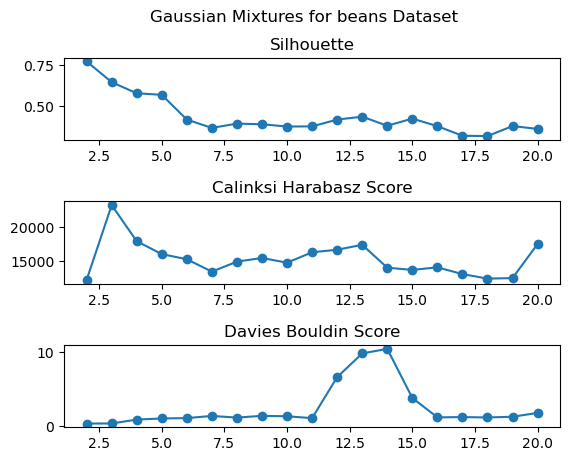

In [366]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    # kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    gm = GaussianMixture(n_components=i, random_state=0)
    results = make_pipeline(StandardScaler(), gm).fit_predict(rp_beans_result)
    silhouette.append(metrics.silhouette_score(
        rp_beans_result,
        results,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            rp_beans_result,
            results
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            rp_beans_result,
            results
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0.75)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('Gaussian Mixtures for beans Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0].plot(range(2, 21), silhouette, marker='o')
axs[0].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1].plot(range(2, 21), ch, marker='o')
axs[1].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[2].plot(range(2, 21), db, marker='o')
axs[2].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

In [367]:
print(82 * "_")
# print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print("init\t\ttime\tsilhouette\tch\tdb")

gm = GaussianMixture(n_components=n_digits_beans, random_state=0)
bench_gm(gm=gm, name="Gaussian 2", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0)
bench_gm(gm=gm, name="Gaussian 3", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0)
bench_gm(gm=gm, name="Gaussian 4", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0)
bench_gm(gm=gm, name="Gaussian 5", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0)
bench_gm(gm=gm, name="Gaussian 6", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=n_digits_beans, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 2 ++", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 3 ++", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 4 ++", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 5 ++", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='k-means++')
bench_gm(gm=gm, name="Gaussian 6 ++", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=n_digits_beans, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 2 random", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=3, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 3 random", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=4, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 4 random", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=5, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 5 random", data=svd_beans_result, labels=beans_y)

gm = GaussianMixture(n_components=6, random_state=0, init_params='random')
bench_gm(gm=gm, name="Gaussian 6 random", data=svd_beans_result, labels=beans_y)

__________________________________________________________________________________
init		time	silhouette	ch	db
Gaussian 2	0.103s	0.069	11345.260	2.366
Gaussian 3	0.039s	0.565	20200.398	0.475
Gaussian 4	0.052s	0.353	13188.070	3.272
Gaussian 5	0.068s	0.072	10378.854	3.993
Gaussian 6	0.067s	0.027	3705.074	4.612
Gaussian 2 ++	0.057s	0.091	3426.675	2.544
Gaussian 3 ++	0.018s	0.542	12399.550	0.503
Gaussian 4 ++	0.025s	0.351	13127.863	3.240
Gaussian 5 ++	0.031s	0.051	10184.951	5.116
Gaussian 6 ++	0.061s	0.042	5749.814	5.039
Gaussian 2 random	0.087s	0.276	3661.091	1.875
Gaussian 3 random	0.034s	0.538	11618.911	0.507
Gaussian 4 random	0.074s	0.275	15399.704	8.603
Gaussian 5 random	0.113s	0.271	10988.462	1.850
Gaussian 6 random	0.107s	0.293	11016.731	6.400


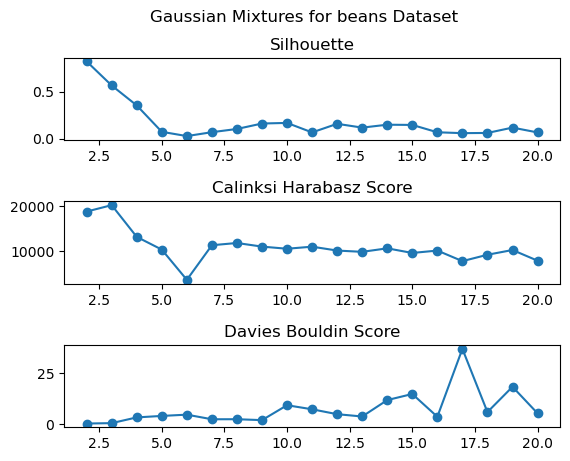

In [368]:
distortion = []
silhouette = []
ch = []
db = []
for i in np.arange(2,21,1):
    # kmeans = KMeans(init="k-means++", n_clusters=i, n_init='auto', random_state=0)
    gm = GaussianMixture(n_components=i, random_state=0)
    results = make_pipeline(StandardScaler(), gm).fit_predict(svd_beans_result)
    silhouette.append(metrics.silhouette_score(
        svd_beans_result,
        results,
        metric="euclidean",
        random_state=0
    ))
    ch.append(
        metrics.calinski_harabasz_score(
            svd_beans_result,
            results
        )
    )
    db.append(
        metrics.davies_bouldin_score(
            svd_beans_result,
            results
        )
    )

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0.75)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('Gaussian Mixtures for beans Dataset')

# fig, axs = plt.subplots(2, 2)
axs[0].plot(range(2, 21), silhouette, marker='o')
axs[0].set_title('Silhouette')
# axs[0, 1].set(xlabel='Number of clusters', ylabel='Silhouette')
axs[1].plot(range(2, 21), ch, marker='o')
axs[1].set_title('Calinksi Harabasz Score')
# axs[1, 0].set(xlabel='Number of clusters', ylabel='Calinski Harabasz Score')
axs[2].plot(range(2, 21), db, marker='o')
axs[2].set_title('Davies Bouldin Score')
# axs[1, 1].set(xlabel='Number of clusters', ylabel='Davies Bouldin Score')


# plt.plot(range(2, 21), distortion, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
plt.show()

# Part 4: Dimensionality Reduction for Neural Network

In [407]:
def cross_validation(model, _X, _y, _cv=5):
   '''Function to perform 5 Folds Cross-Validation
      Parameters
      ----------
   model: Python Class, default=None
            This is the machine learning algorithm to be used for training.
   _X: array
         This is the matrix of features.
   _y: array
         This is the target variable.
   _cv: int, default=5
         Determines the number of folds for cross-validation.
      Returns
      -------
      The function returns a dictionary containing the metrics 'accuracy', 'precision',
      'recall', 'f1' for both training set and validation set.
   '''
   # _scoring = ['accuracy', 'precision', 'recall', 'f1']
   _scoring = 'f1_micro'
   results = cross_validate(estimator=model,
                              X=_X,
                              y=_y,
                              cv=_cv,
                              scoring=_scoring,
                              return_train_score=True)
      
   return results

def get_training_time(model, X, y):
   training_sizes = np.arange(100, 2200, 50)
   training_times = []
   for train_size in training_sizes:
      i = np.random.randint(X.shape[0], size=train_size)
      X_subset = X.iloc[i,:]
      y_subset = y.iloc[i]
      scores = cross_validate(model, X_subset, y_subset, cv=5, scoring='f1_micro', return_train_score=True)
      avg_time = np.mean(scores['fit_time'])
      training_times.append(avg_time)
   
   plt.plot(training_sizes, training_times,
      label = "Training Time", color = 'b')
   # Creating the plot
   plt.title(f"Training Times with {model.__class__.__name__}")
   plt.xlabel("Num. Samples")
   plt.ylabel("Training Time")
   plt.tight_layout()
   plt.legend(loc = 'best')
   plt.show()

def model_evaluation(y_test, y_pred):
   accuracy = metrics.accuracy_score(y_test, y_pred)
   f1 = metrics.f1_score(y_test, y_pred, average='micro')
   return accuracy, f1

In [373]:
X_train_beans_pca, X_test_beans_pca, y_train_beans_pca, y_test_beans_pca = train_test_split(result_pca_beans, beans_y, test_size = 0.2, random_state=0)

one_layer_sizes = [(10,), (20,), (30,), (40,), (50,), (60,), (70,), (80,), (90,), (100,), (110,), (120,), (130,), (140,), (150,), (160,), (170,), (180,), (190,), (200,), (250,), (300,)]
one_layer_train_results = []
one_layer_val_results = []
one_layer_train_time = []
for i in one_layer_sizes:
    mlp = MLPClassifier(random_state=0, hidden_layer_sizes=i)
    mlp_result = cross_validation(mlp, X_train_beans_pca, y_train_beans_pca, 5)
    one_layer_train_results.append(mlp_result["train_score"].mean())
    one_layer_val_results.append(mlp_result["test_score"].mean())
    one_layer_train_time.append(mlp_result['fit_time'].mean())

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

0.9375


<Figure size 640x480 with 0 Axes>

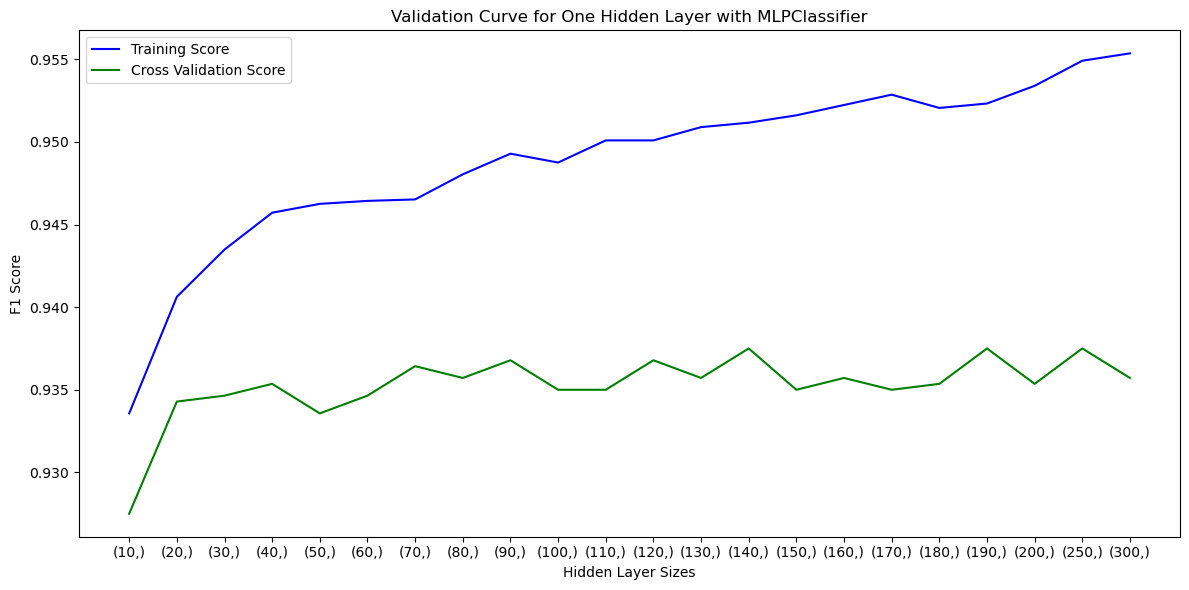

In [374]:
labels = ['(10,)', '(20,)', '(30,)', '(40,)', '(50,)', '(60,)', '(70,)', '(80,)', '(90,)', '(100,)', '(110,)', '(120,)', '(130,)', '(140,)', '(150,)', '(160,)', '(170,)', '(180,)', '(190,)', '(200,)', '(250,)', '(300,)']

fig = plt.figure()
plt.figure(figsize=(12,6))
plt.plot(labels, one_layer_train_results,
    label = "Training Score", color = 'b')
plt.plot(labels, one_layer_val_results,
    label = "Cross Validation Score", color = 'g')
# plt.plot(labels, one_layer_train_time,
#     label = "Training Time", color = 'r')

# Creating the plot
plt.title(f"Validation Curve for One Hidden Layer with {mlp.__class__.__name__}")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc = 'best')


print(max(one_layer_val_results))

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

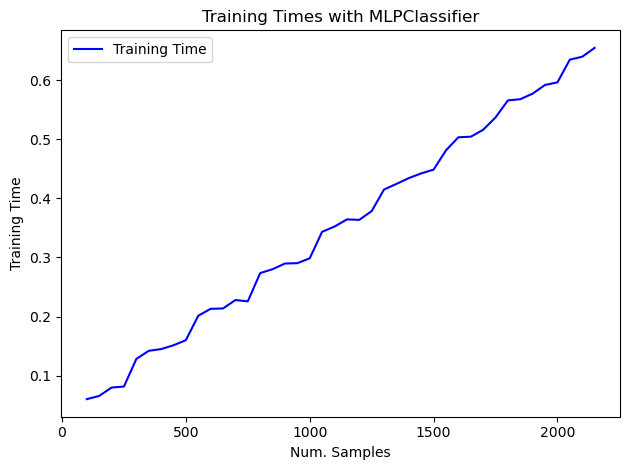

In [377]:
get_training_time(MLPClassifier(random_state=0, hidden_layer_sizes=(90,)), X_train_beans_pca, y_train_beans_pca)

In [410]:
mlp_pca = MLPClassifier(random_state=0, hidden_layer_sizes=(90,))

mlp_pca = mlp_pca.fit(X_train_beans_pca, y_train_beans_pca)
y_pred_beans_pca = mlp_pca.predict(X_test_beans_pca)

accuracy, f1 = model_evaluation(y_test_beans_pca, y_pred_beans_pca)
print('Accuracy: ', accuracy)
print('F1 Micro: ', f1)

Accuracy:  0.93
F1 Micro:  0.93


c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Number of iterations:  200
Number of training samples seen 560000
Number of features seen:  7
Best Loss:  0.13301644179273092


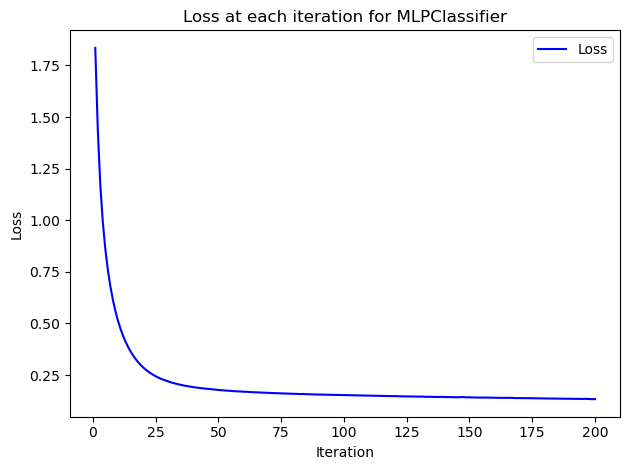

In [416]:
loss = mlp_pca.loss_curve_
param_range = np.arange(1, len(loss)+1, 1)

fig = plt.figure()
plt.plot(param_range, loss,
    label = "Loss", color = 'b')

# Creating the plot
plt.title(f"Loss at each iteration for {mlp_pca.__class__.__name__}")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend(loc = 'best')

print("Number of iterations: ", mlp_pca.n_iter_)
print("Number of training samples seen", mlp_pca.t_)
print("Number of features seen: ", mlp_pca.n_features_in_)
print("Best Loss: ", mlp_pca.best_loss_)

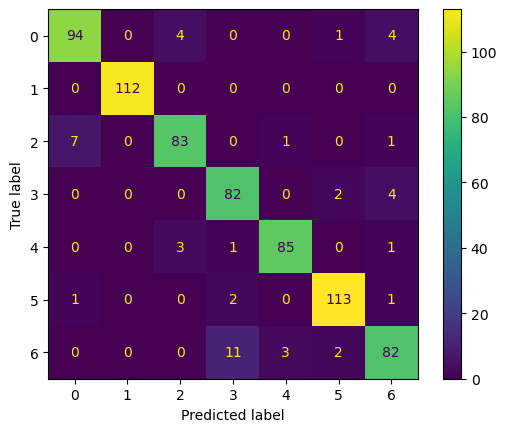

In [429]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_beans_pca, y_pred_beans_pca, labels=mlp_pca.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_pca.classes_)
disp.plot()

In [420]:
ica_beans_result.head()

,fastica0,fastica1,fastica2,fastica3,fastica4,fastica5,fastica6,fastica7,fastica8,fastica9,fastica10,fastica11,fastica12
2579,-0.023713,-0.015495,0.017653,0.001249,0.005245,-0.008319,-0.006975,0.013625,-0.000423,-0.028301,-0.010699,0.007653,-0.003788
3079,-0.013599,0.008882,0.107110,0.002871,0.015576,-0.006181,-0.001010,0.001603,-0.042805,-0.039759,-0.002639,0.033282,0.013669
3029,-0.000249,-0.021616,0.041529,0.004752,-0.003511,-0.013500,0.002602,0.013308,0.013752,0.001391,0.009604,-0.001152,0.002591
2775,-0.009742,-0.018530,0.002201,0.001162,0.002179,-0.009568,-0.005910,0.010696,0.007186,0.024656,-0.000336,-0.003000,-0.015795
2666,-0.011886,-0.017055,0.006313,-0.000223,-0.000717,-0.013408,-0.004320,-0.003823,0.004940,0.010488,-0.000738,0.001880,-0.010322


In [378]:
X_train_beans_ica, X_test_beans_ica, y_train_beans_ica, y_test_beans_ica = train_test_split(ica_beans_result, beans_y, test_size = 0.2, random_state=0)

one_layer_sizes = [(10,), (20,), (30,), (40,), (50,), (60,), (70,), (80,), (90,), (100,), (110,), (120,), (130,), (140,), (150,), (160,), (170,), (180,), (190,), (200,), (250,), (300,)]
one_layer_train_results = []
one_layer_val_results = []
one_layer_train_time = []
for i in one_layer_sizes:
    mlp = MLPClassifier(random_state=0, hidden_layer_sizes=i)
    mlp_result = cross_validation(mlp, X_train_beans_ica, y_train_beans_ica, 5)
    one_layer_train_results.append(mlp_result["train_score"].mean())
    one_layer_val_results.append(mlp_result["test_score"].mean())
    one_layer_train_time.append(mlp_result['fit_time'].mean())

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

0.9285714285714285


<Figure size 640x480 with 0 Axes>

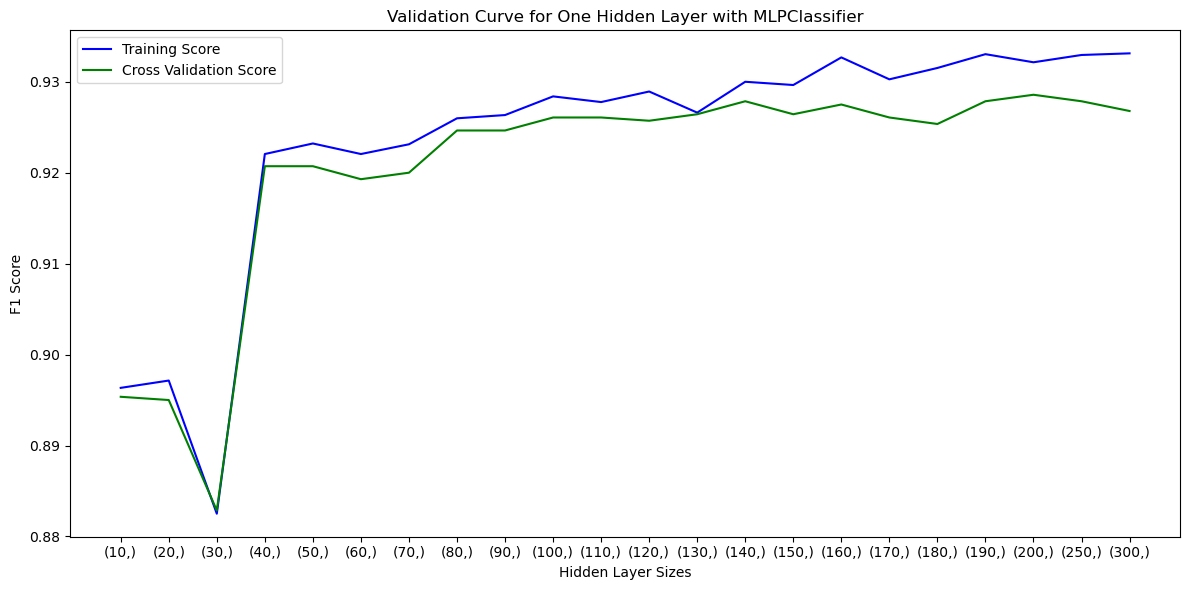

In [379]:
labels = ['(10,)', '(20,)', '(30,)', '(40,)', '(50,)', '(60,)', '(70,)', '(80,)', '(90,)', '(100,)', '(110,)', '(120,)', '(130,)', '(140,)', '(150,)', '(160,)', '(170,)', '(180,)', '(190,)', '(200,)', '(250,)', '(300,)']

fig = plt.figure()
plt.figure(figsize=(12,6))
plt.plot(labels, one_layer_train_results,
    label = "Training Score", color = 'b')
plt.plot(labels, one_layer_val_results,
    label = "Cross Validation Score", color = 'g')
# plt.plot(labels, one_layer_train_time,
#     label = "Training Time", color = 'r')

# Creating the plot
plt.title(f"Validation Curve for One Hidden Layer with {mlp.__class__.__name__}")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc = 'best')


print(max(one_layer_val_results))

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

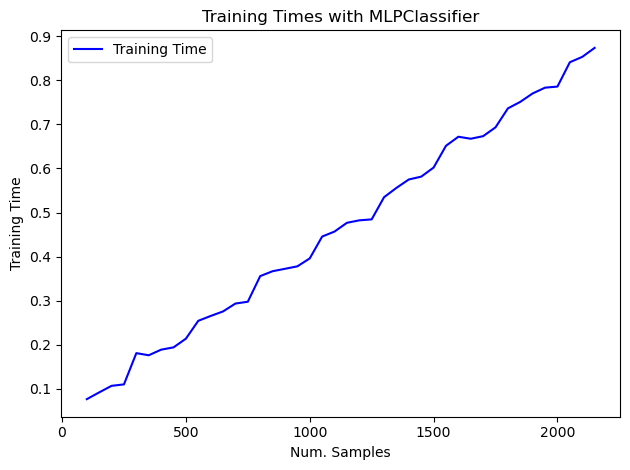

In [380]:
get_training_time(MLPClassifier(random_state=0, hidden_layer_sizes=(200,)), X_train_beans_ica, y_train_beans_ica)

In [439]:
mlp_ica = MLPClassifier(random_state=0, hidden_layer_sizes=(200,))

mlp_ica = mlp_ica.fit(X_train_beans_ica, y_train_beans_ica)
y_pred_beans_ica = mlp_ica.predict(X_test_beans_ica)

accuracy, f1 = model_evaluation(y_test_beans_ica, y_pred_beans_ica)
print('Accuracy: ', accuracy)
print('F1 Micro: ', f1)

Accuracy:  0.9214285714285714
F1 Micro:  0.9214285714285714


c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Number of iterations:  200
Number of training samples seen 560000
Number of features seen:  13
Best Loss:  0.19377719470863122


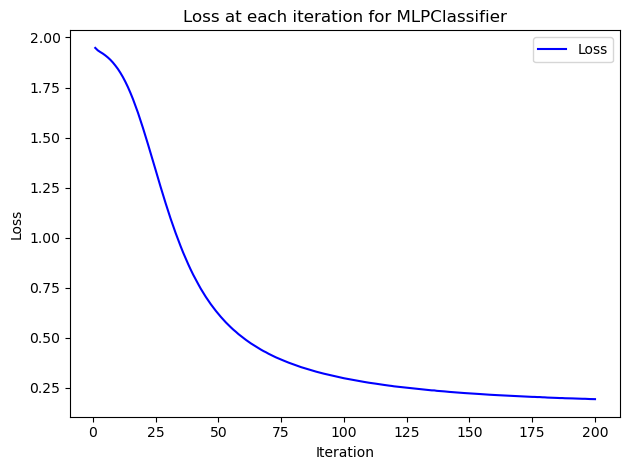

In [440]:
loss = mlp_ica.loss_curve_
param_range = np.arange(1, len(loss)+1, 1)

fig = plt.figure()
plt.plot(param_range, loss,
    label = "Loss", color = 'b')

# Creating the plot
plt.title(f"Loss at each iteration for {mlp_ica.__class__.__name__}")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend(loc = 'best')

print("Number of iterations: ", mlp_ica.n_iter_)
print("Number of training samples seen", mlp_ica.t_)
print("Number of features seen: ", mlp_ica.n_features_in_)
print("Best Loss: ", mlp_ica.best_loss_)

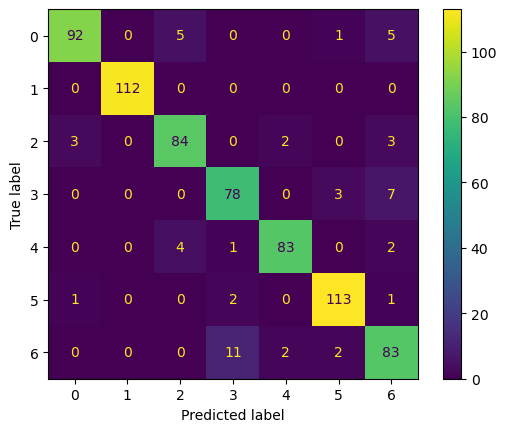

In [441]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_beans_ica, y_pred_beans_ica, labels=mlp_ica.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_ica.classes_)
disp.plot()

In [421]:
scaler = StandardScaler() 
rp_beans_result = pd.DataFrame(scaler.fit_transform(rp_beans_result), index=rp_beans_result.index, columns=rp_beans_result.columns)

X_train_beans_rp, X_test_beans_rp, y_train_beans_rp, y_test_beans_rp = train_test_split(rp_beans_result, beans_y, test_size = 0.2, random_state=0)

one_layer_sizes = [(10,), (20,), (30,), (40,), (50,), (60,), (70,), (80,), (90,), (100,), (110,), (120,), (130,), (140,), (150,), (160,), (170,), (180,), (190,), (200,), (250,), (300,)]
one_layer_train_results = []
one_layer_val_results = []
one_layer_train_time = []
for i in one_layer_sizes:
    mlp = MLPClassifier(random_state=0, hidden_layer_sizes=i)
    mlp_result = cross_validation(mlp, X_train_beans_rp, y_train_beans_rp, 5)
    one_layer_train_results.append(mlp_result["train_score"].mean())
    one_layer_val_results.append(mlp_result["test_score"].mean())
    one_layer_train_time.append(mlp_result['fit_time'].mean())

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

0.6360714285714286


<Figure size 640x480 with 0 Axes>

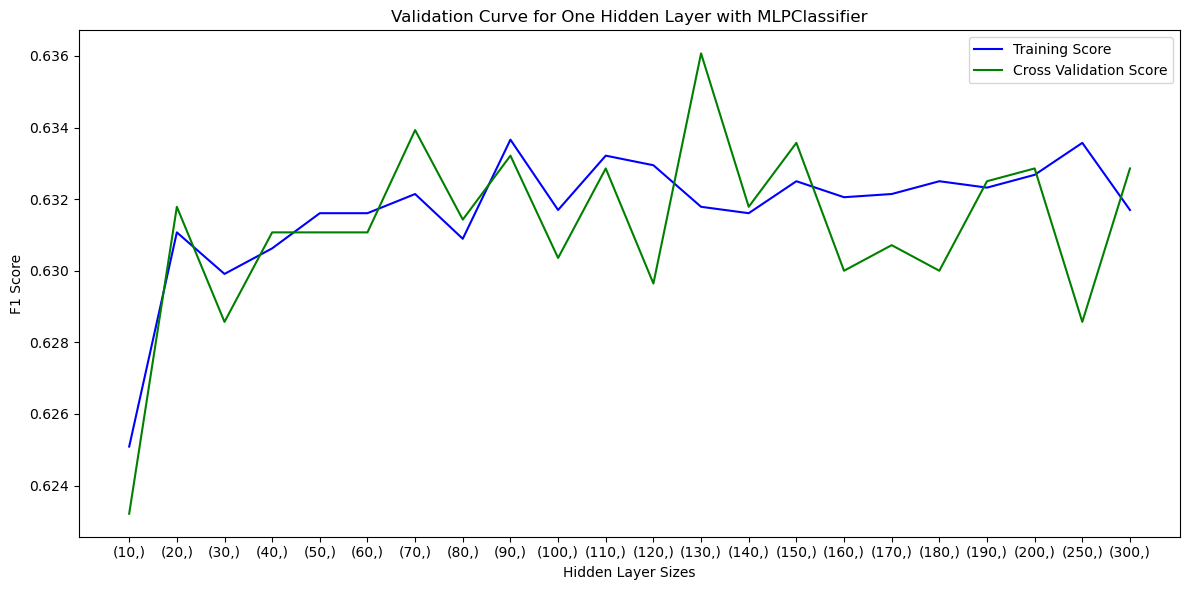

In [422]:
labels = ['(10,)', '(20,)', '(30,)', '(40,)', '(50,)', '(60,)', '(70,)', '(80,)', '(90,)', '(100,)', '(110,)', '(120,)', '(130,)', '(140,)', '(150,)', '(160,)', '(170,)', '(180,)', '(190,)', '(200,)', '(250,)', '(300,)']

fig = plt.figure()
plt.figure(figsize=(12,6))
plt.plot(labels, one_layer_train_results,
    label = "Training Score", color = 'b')
plt.plot(labels, one_layer_val_results,
    label = "Cross Validation Score", color = 'g')
# plt.plot(labels, one_layer_train_time,
#     label = "Training Time", color = 'r')

# Creating the plot
plt.title(f"Validation Curve for One Hidden Layer with {mlp.__class__.__name__}")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc = 'best')


print(max(one_layer_val_results))

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

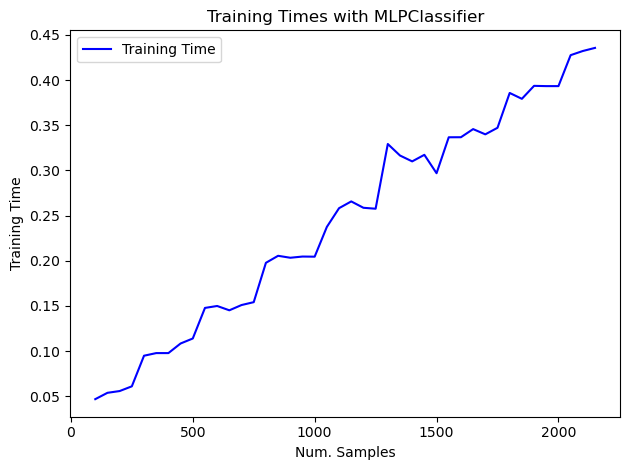

In [423]:
get_training_time(MLPClassifier(random_state=0, hidden_layer_sizes=(10,)), X_train_beans_rp, y_train_beans_rp)

In [424]:
mlp_rp = MLPClassifier(random_state=0, hidden_layer_sizes=(90,))

mlp_rp = mlp_rp.fit(X_train_beans_rp, y_train_beans_rp)
y_pred_beans_rp = mlp_rp.predict(X_test_beans_rp)

accuracy, f1 = model_evaluation(y_test_beans_rp, y_pred_beans_rp)
print('Accuracy: ', accuracy)
print('F1 Micro: ', f1)

Accuracy:  0.61
F1 Micro:  0.61


c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Number of iterations:  200
Number of training samples seen 560000
Number of features seen:  4
Best Loss:  0.7824642322353096


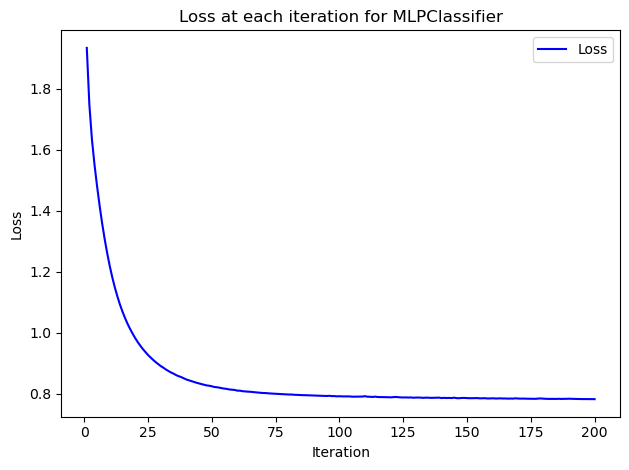

In [425]:
loss = mlp_rp.loss_curve_
param_range = np.arange(1, len(loss)+1, 1)

fig = plt.figure()
plt.plot(param_range, loss,
    label = "Loss", color = 'b')

# Creating the plot
plt.title(f"Loss at each iteration for {mlp_rp.__class__.__name__}")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend(loc = 'best')

print("Number of iterations: ", mlp_rp.n_iter_)
print("Number of training samples seen", mlp_rp.t_)
print("Number of features seen: ", mlp_rp.n_features_in_)
print("Best Loss: ", mlp_rp.best_loss_)

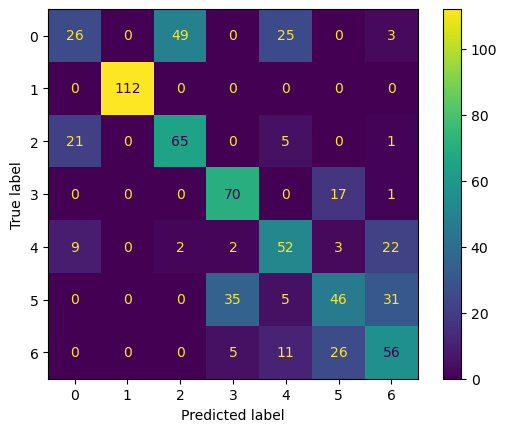

In [427]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_beans_rp, y_pred_beans_rp, labels=mlp_rp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_rp.classes_)
disp.plot()

In [431]:
scaler = StandardScaler() 
svd_beans_result = pd.DataFrame(scaler.fit_transform(svd_beans_result), index=svd_beans_result.index, columns=svd_beans_result.columns)

X_train_beans_svd, X_test_beans_svd, y_train_beans_svd, y_test_beans_svd = train_test_split(svd_beans_result, beans_y, test_size = 0.2, random_state=0)

one_layer_sizes = [(10,), (20,), (30,), (40,), (50,), (60,), (70,), (80,), (90,), (100,), (110,), (120,), (130,), (140,), (150,), (160,), (170,), (180,), (190,), (200,), (250,), (300,)]
one_layer_train_results = []
one_layer_val_results = []
one_layer_train_time = []
for i in one_layer_sizes:
    mlp = MLPClassifier(random_state=0, hidden_layer_sizes=i)
    mlp_result = cross_validation(mlp, X_train_beans_svd, y_train_beans_svd, 5)
    one_layer_train_results.append(mlp_result["train_score"].mean())
    one_layer_val_results.append(mlp_result["test_score"].mean())
    one_layer_train_time.append(mlp_result['fit_time'].mean())

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

0.9382142857142857


<Figure size 640x480 with 0 Axes>

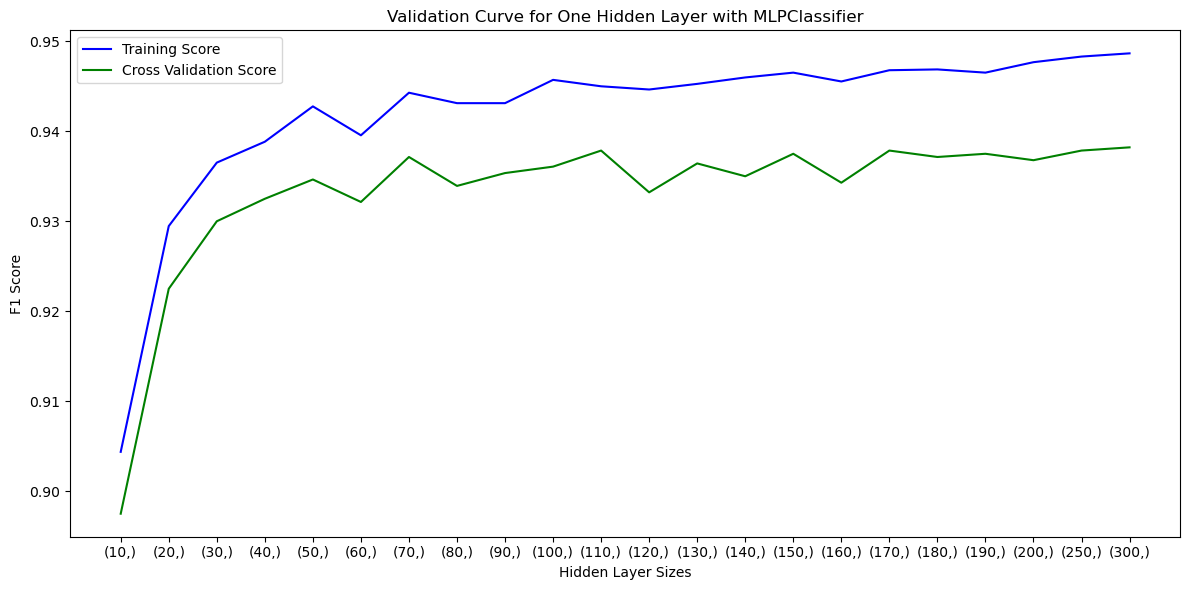

In [432]:
labels = ['(10,)', '(20,)', '(30,)', '(40,)', '(50,)', '(60,)', '(70,)', '(80,)', '(90,)', '(100,)', '(110,)', '(120,)', '(130,)', '(140,)', '(150,)', '(160,)', '(170,)', '(180,)', '(190,)', '(200,)', '(250,)', '(300,)']

fig = plt.figure()
plt.figure(figsize=(12,6))
plt.plot(labels, one_layer_train_results,
    label = "Training Score", color = 'b')
plt.plot(labels, one_layer_val_results,
    label = "Cross Validation Score", color = 'g')
# plt.plot(labels, one_layer_train_time,
#     label = "Training Time", color = 'r')

# Creating the plot
plt.title(f"Validation Curve for One Hidden Layer with {mlp.__class__.__name__}")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc = 'best')


print(max(one_layer_val_results))

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

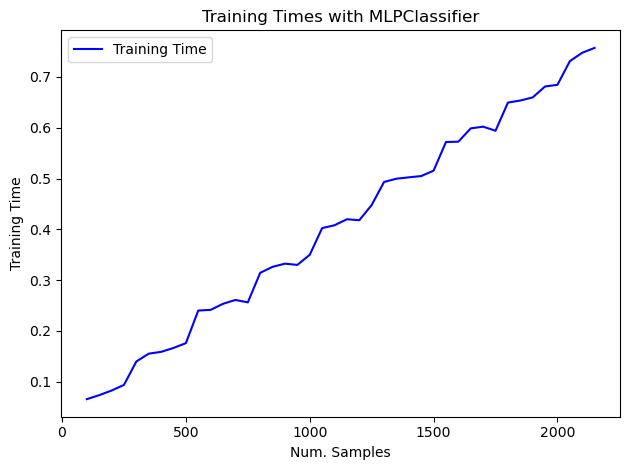

In [433]:
get_training_time(MLPClassifier(random_state=0, hidden_layer_sizes=(140,)), X_train_beans_svd, y_train_beans_svd)

In [442]:
mlp_svd = MLPClassifier(random_state=0, hidden_layer_sizes=(110,))

mlp_svd = mlp_svd.fit(X_train_beans_svd, y_train_beans_svd)
y_pred_beans_svd = mlp_svd.predict(X_test_beans_svd)

accuracy, f1 = model_evaluation(y_test_beans_svd, y_pred_beans_svd)
print('Accuracy: ', accuracy)
print('F1 Micro: ', f1)

Accuracy:  0.9242857142857143
F1 Micro:  0.9242857142857143


c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Number of iterations:  200
Number of training samples seen 560000
Number of features seen:  6
Best Loss:  0.15176346108875793


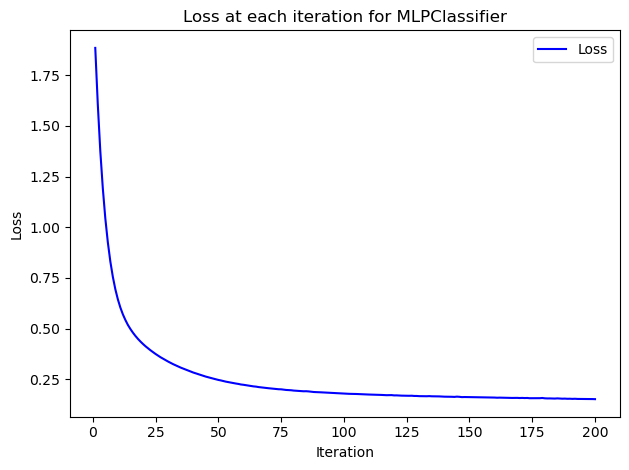

In [443]:
loss = mlp_svd.loss_curve_
param_range = np.arange(1, len(loss)+1, 1)

fig = plt.figure()
plt.plot(param_range, loss,
    label = "Loss", color = 'b')

# Creating the plot
plt.title(f"Loss at each iteration for {mlp_svd.__class__.__name__}")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend(loc = 'best')

print("Number of iterations: ", mlp_svd.n_iter_)
print("Number of training samples seen", mlp_svd.t_)
print("Number of features seen: ", mlp_svd.n_features_in_)
print("Best Loss: ", mlp_svd.best_loss_)

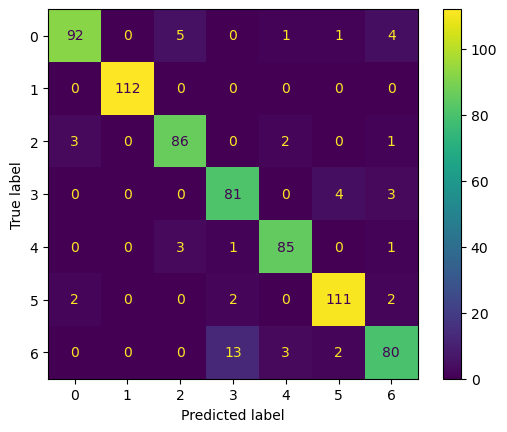

In [444]:
cm = confusion_matrix(y_test_beans_svd, y_pred_beans_svd, labels=mlp_svd.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_svd.classes_)
disp.plot()

# Part 5: Clustering then train NN

In [393]:
kmeans_beans = KMeans(init="k-means++", n_clusters=3, n_init='auto', random_state=0)
results_kmeans_beans = make_pipeline(StandardScaler(), kmeans_beans).fit_predict(beans_x)

In [402]:
scaler = StandardScaler() 
beans_clustered = pd.DataFrame(scaler.fit_transform(beans_x), index=beans_x.index, columns=beans_x.columns)
beans_clustered['Cluster'] = results_kmeans_beans
beans_clustered.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Cluster
2579,-0.043041,0.209788,0.015767,0.163757,-0.282147,0.001936,-0.041951,0.096190,-0.068713,-0.229679,-1.071278,0.167109,-0.465764,-0.232832,0.128555,-0.225516,0
3079,0.178123,0.716976,0.035587,0.684862,-1.045201,-0.975991,0.190978,0.346383,0.002524,-1.609837,-2.728140,1.034040,-0.954347,0.058811,1.028221,-0.747095,0
3029,0.146070,0.520515,0.414106,0.162731,0.507223,0.632346,0.149301,0.311184,0.736085,-0.479173,-1.726912,-0.574284,-0.475433,-0.705067,-0.595219,0.370683,0
2775,0.030305,0.209321,0.118939,0.204271,-0.150764,0.126996,0.031097,0.181131,0.467525,-0.186554,-0.400544,0.065824,-0.530008,-0.337698,0.027198,0.921059,0
2666,-0.012287,0.196035,0.105103,0.136289,-0.055649,0.211749,-0.006419,0.132059,0.495225,-0.867156,-0.682938,-0.060804,-0.437873,-0.370311,-0.098418,-0.096127,0


In [403]:
X_train_beans_kmeans, X_test_beans_kmeans, y_train_beans_kmeans, y_test_beans_kmeans = train_test_split(beans_clustered, beans_y, test_size = 0.2, random_state=0)

one_layer_sizes = [(10,), (20,), (30,), (40,), (50,), (60,), (70,), (80,), (90,), (100,), (110,), (120,), (130,), (140,), (150,), (160,), (170,), (180,), (190,), (200,), (250,), (300,)]
one_layer_train_results = []
one_layer_val_results = []
one_layer_train_time = []
for i in one_layer_sizes:
    mlp = MLPClassifier(random_state=0, hidden_layer_sizes=i)
    mlp_result = cross_validation(mlp, X_train_beans_kmeans, y_train_beans_kmeans, 5)
    one_layer_train_results.append(mlp_result["train_score"].mean())
    one_layer_val_results.append(mlp_result["test_score"].mean())
    one_layer_train_time.append(mlp_result['fit_time'].mean())

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

0.9389285714285714


<Figure size 640x480 with 0 Axes>

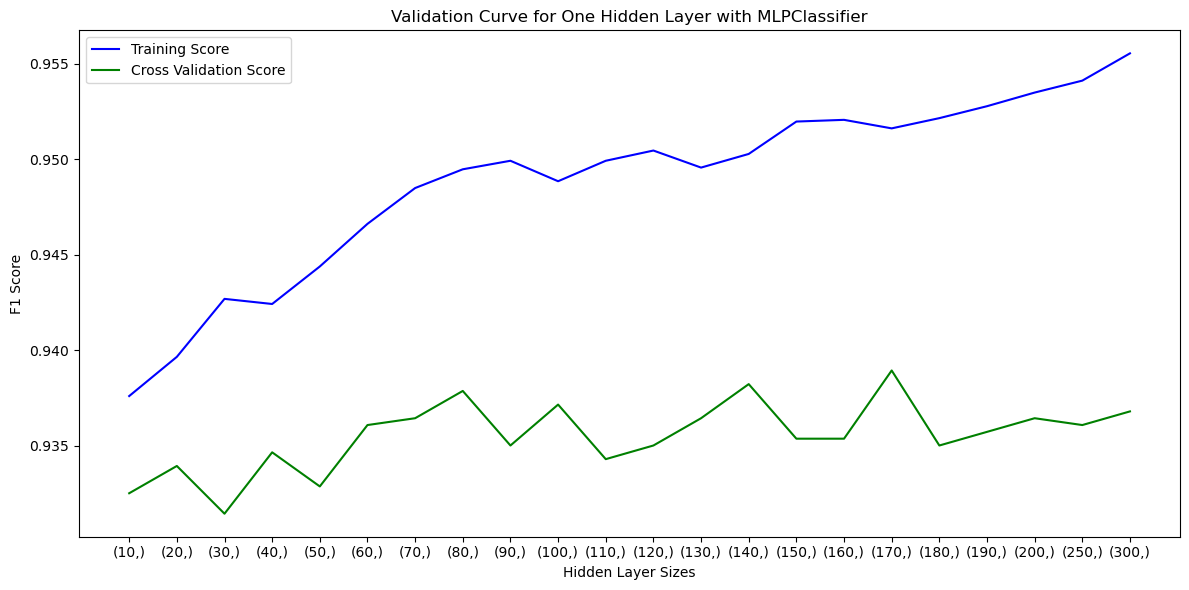

In [404]:
labels = ['(10,)', '(20,)', '(30,)', '(40,)', '(50,)', '(60,)', '(70,)', '(80,)', '(90,)', '(100,)', '(110,)', '(120,)', '(130,)', '(140,)', '(150,)', '(160,)', '(170,)', '(180,)', '(190,)', '(200,)', '(250,)', '(300,)']

fig = plt.figure()
plt.figure(figsize=(12,6))
plt.plot(labels, one_layer_train_results,
    label = "Training Score", color = 'b')
plt.plot(labels, one_layer_val_results,
    label = "Cross Validation Score", color = 'g')
# plt.plot(labels, one_layer_train_time,
#     label = "Training Time", color = 'r')

# Creating the plot
plt.title(f"Validation Curve for One Hidden Layer with {mlp.__class__.__name__}")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc = 'best')


print(max(one_layer_val_results))

In [445]:
mlp_kmeans = MLPClassifier(random_state=0, hidden_layer_sizes=(170,))

mlp_kmeans = mlp_kmeans.fit(X_train_beans_kmeans, y_train_beans_kmeans)
y_pred_beans_kmeans = mlp_kmeans.predict(X_test_beans_kmeans)

accuracy, f1 = model_evaluation(y_test_beans_kmeans, y_pred_beans_kmeans)
print('Accuracy: ', accuracy)
print('F1 Micro: ', f1)

Accuracy:  0.9271428571428572
F1 Micro:  0.9271428571428572


c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Number of iterations:  200
Number of training samples seen 560000
Number of features seen:  17
Best Loss:  0.12437157738946983


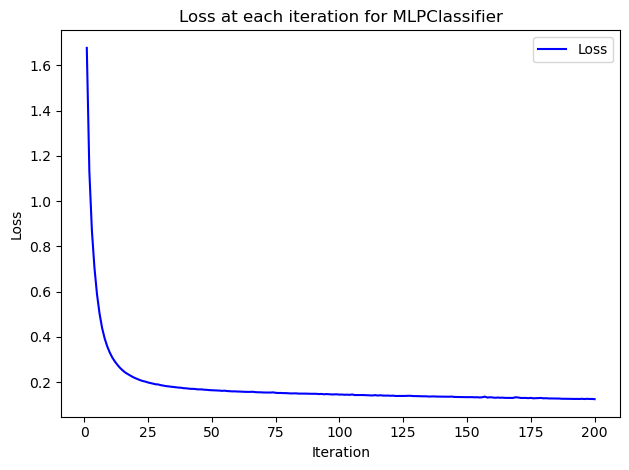

In [446]:
loss = mlp_kmeans.loss_curve_
param_range = np.arange(1, len(loss)+1, 1)

fig = plt.figure()
plt.plot(param_range, loss,
    label = "Loss", color = 'b')

# Creating the plot
plt.title(f"Loss at each iteration for {mlp_kmeans.__class__.__name__}")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend(loc = 'best')

print("Number of iterations: ", mlp_kmeans.n_iter_)
print("Number of training samples seen", mlp_kmeans.t_)
print("Number of features seen: ", mlp_kmeans.n_features_in_)
print("Best Loss: ", mlp_kmeans.best_loss_)

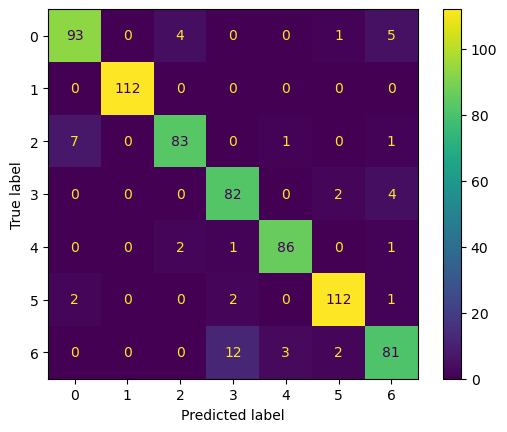

In [447]:
cm = confusion_matrix(y_test_beans_kmeans, y_pred_beans_kmeans, labels=mlp_kmeans.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_kmeans.classes_)
disp.plot()

In [405]:
gm = GaussianMixture(n_components=3, random_state=0)
results_gm_beans = make_pipeline(StandardScaler(), gm).fit_predict(beans_x)

scaler = StandardScaler() 
beans_clustered_gm = pd.DataFrame(scaler.fit_transform(beans_x), index=beans_x.index, columns=beans_x.columns)
beans_clustered_gm['Cluster'] = results_gm_beans
beans_clustered_gm.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Cluster
2579,-0.043041,0.209788,0.015767,0.163757,-0.282147,0.001936,-0.041951,0.096190,-0.068713,-0.229679,-1.071278,0.167109,-0.465764,-0.232832,0.128555,-0.225516,1
3079,0.178123,0.716976,0.035587,0.684862,-1.045201,-0.975991,0.190978,0.346383,0.002524,-1.609837,-2.728140,1.034040,-0.954347,0.058811,1.028221,-0.747095,1
3029,0.146070,0.520515,0.414106,0.162731,0.507223,0.632346,0.149301,0.311184,0.736085,-0.479173,-1.726912,-0.574284,-0.475433,-0.705067,-0.595219,0.370683,1
2775,0.030305,0.209321,0.118939,0.204271,-0.150764,0.126996,0.031097,0.181131,0.467525,-0.186554,-0.400544,0.065824,-0.530008,-0.337698,0.027198,0.921059,1
2666,-0.012287,0.196035,0.105103,0.136289,-0.055649,0.211749,-0.006419,0.132059,0.495225,-0.867156,-0.682938,-0.060804,-0.437873,-0.370311,-0.098418,-0.096127,1


In [438]:
X_train_beans_gm, X_test_beans_gm, y_train_beans_gm, y_test_beans_gm = train_test_split(beans_clustered_gm, beans_y, test_size = 0.2, random_state=0)

one_layer_sizes = [(10,), (20,), (30,), (40,), (50,), (60,), (70,), (80,), (90,), (100,), (110,), (120,), (130,), (140,), (150,), (160,), (170,), (180,), (190,), (200,), (250,), (300,)]
one_layer_train_results = []
one_layer_val_results = []
one_layer_train_time = []
for i in one_layer_sizes:
    mlp = MLPClassifier(random_state=0, hidden_layer_sizes=i)
    mlp_result = cross_validation(mlp, X_train_beans_gm, y_train_beans_gm, 5)
    one_layer_train_results.append(mlp_result["train_score"].mean())
    one_layer_val_results.append(mlp_result["test_score"].mean())
    one_layer_train_time.append(mlp_result['fit_time'].mean())

c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\funkj\anaconda3\envs\ML\lib\sit

0.9382142857142857


<Figure size 640x480 with 0 Axes>

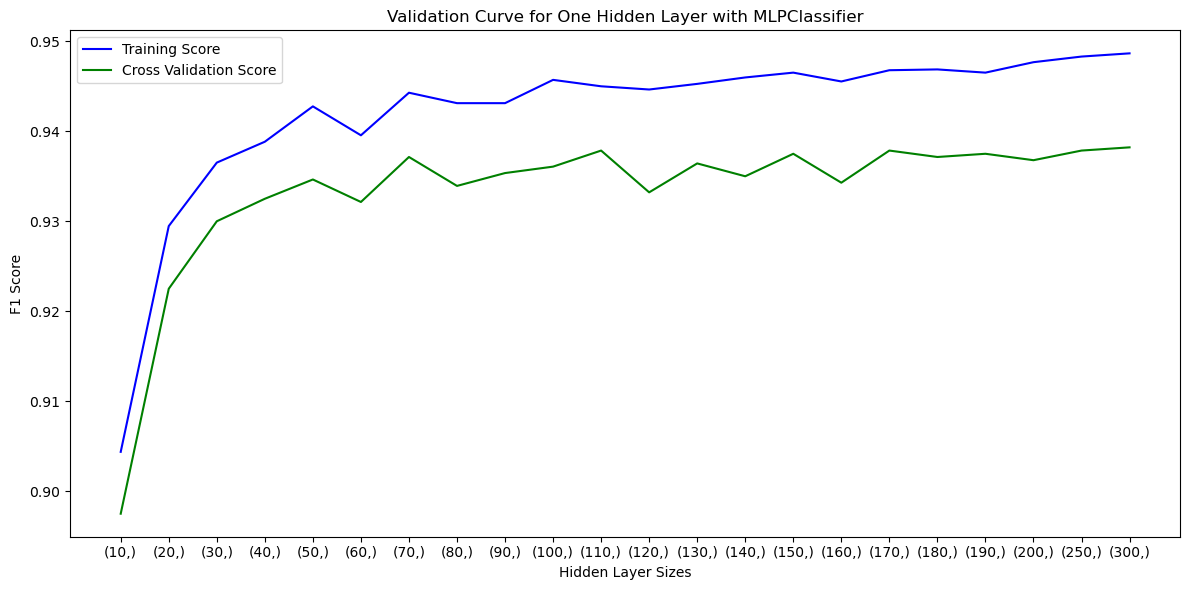

In [437]:
labels = ['(10,)', '(20,)', '(30,)', '(40,)', '(50,)', '(60,)', '(70,)', '(80,)', '(90,)', '(100,)', '(110,)', '(120,)', '(130,)', '(140,)', '(150,)', '(160,)', '(170,)', '(180,)', '(190,)', '(200,)', '(250,)', '(300,)']

fig = plt.figure()
plt.figure(figsize=(12,6))
plt.plot(labels, one_layer_train_results,
    label = "Training Score", color = 'b')
plt.plot(labels, one_layer_val_results,
    label = "Cross Validation Score", color = 'g')
# plt.plot(labels, one_layer_train_time,
#     label = "Training Time", color = 'r')

# Creating the plot
plt.title(f"Validation Curve for One Hidden Layer with {mlp.__class__.__name__}")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.legend(loc = 'best')


print(max(one_layer_val_results))

In [448]:
mlp_gm = MLPClassifier(random_state=0, hidden_layer_sizes=(170,))

mlp_gm = mlp_gm.fit(X_train_beans_gm, y_train_beans_gm)
y_pred_beans_gm = mlp_gm.predict(X_test_beans_gm)

accuracy, f1 = model_evaluation(y_test_beans_gm, y_pred_beans_gm)
print('Accuracy: ', accuracy)
print('F1 Micro: ', f1)

Accuracy:  0.93
F1 Micro:  0.93


c:\Users\funkj\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Number of iterations:  200
Number of training samples seen 560000
Number of features seen:  17
Best Loss:  0.12395203877514871


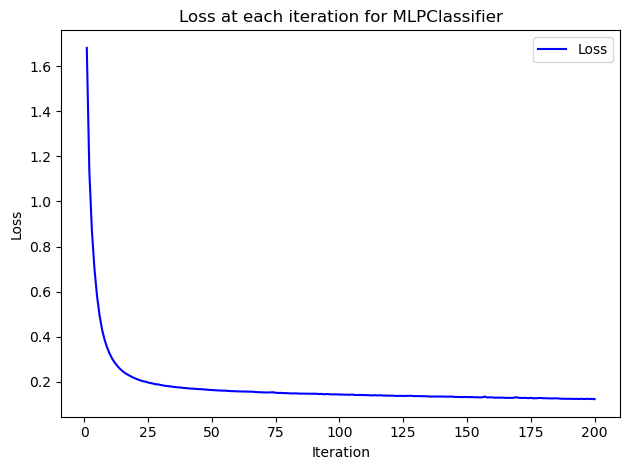

In [449]:
loss = mlp_gm.loss_curve_
param_range = np.arange(1, len(loss)+1, 1)

fig = plt.figure()
plt.plot(param_range, loss,
    label = "Loss", color = 'b')

# Creating the plot
plt.title(f"Loss at each iteration for {mlp_gm.__class__.__name__}")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend(loc = 'best')

print("Number of iterations: ", mlp_gm.n_iter_)
print("Number of training samples seen", mlp_gm.t_)
print("Number of features seen: ", mlp_gm.n_features_in_)
print("Best Loss: ", mlp_gm.best_loss_)

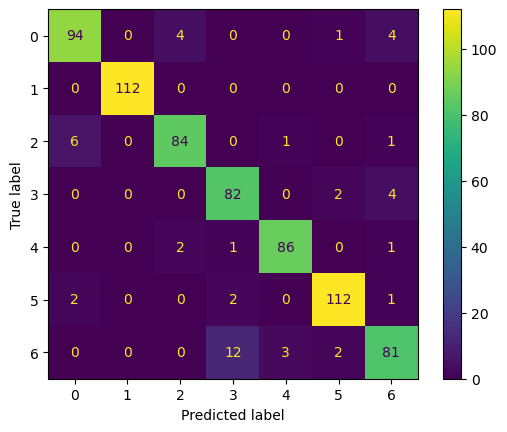

In [450]:
cm = confusion_matrix(y_test_beans_gm, y_pred_beans_gm, labels=mlp_gm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_gm.classes_)
disp.plot()